In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from matplotlib.colors import LogNorm

import seaborn as sns 
import tables 
import pickle
import warnings
import iminuit as mi
from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d

warnings.filterwarnings(action='once')
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

/Users/yang/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [3]:
lifetime = 86400*365*5 # 1 year!  # independent of eff area calculation and subsedquent asimov test
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-3-2-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/'

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


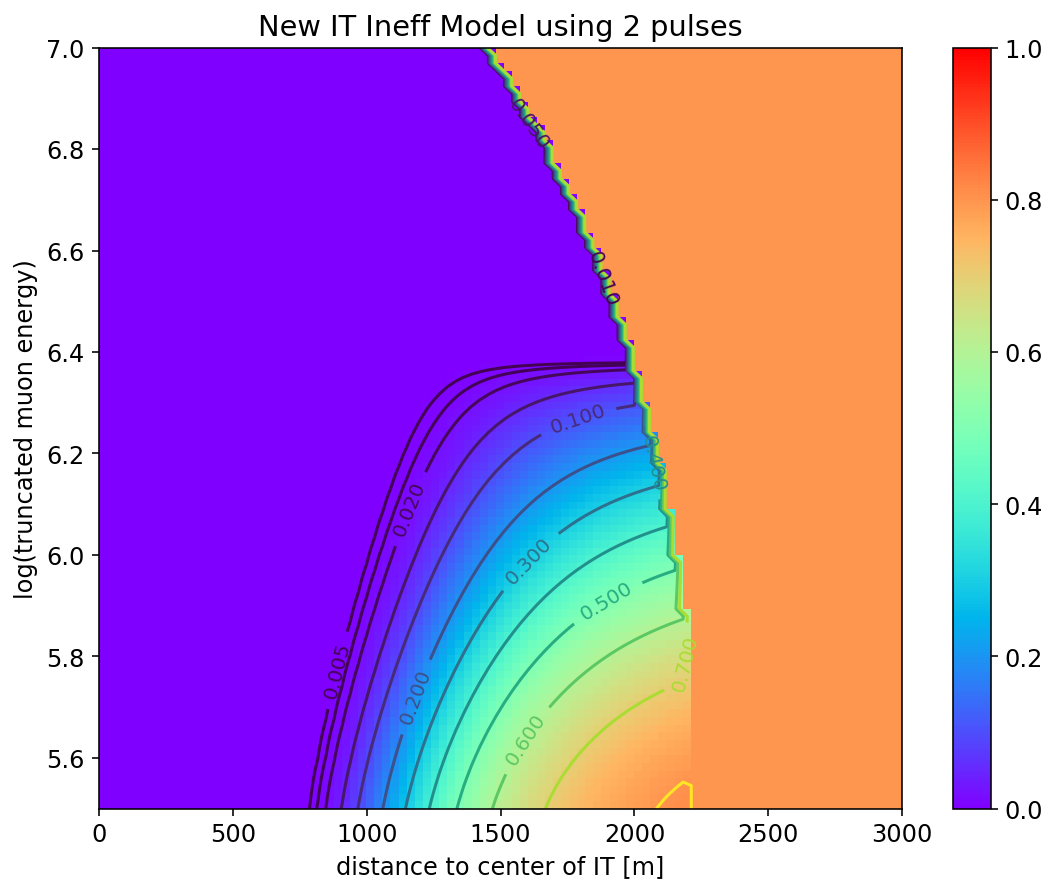

In [4]:
# OLD and NEW ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model_robust_2.txt')

def ineff_model_new(dist,E): # E: log10 of energy!!! 
    
    a = params[0] * (E - params[1])**2 + params[2]
    b = params[3] * (E - params[4])**2 + params[5]

    val = a * np.exp(-b/(dist/2000)**(4.2)) # 2 pulse robust

    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
    val[E > 5.47+2*np.sqrt(1 - ((dist-20)/2210)**2) ]=0.8
    val[dist > 2210] = 0.8
    return val

xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model_new(xg,yg)

plt.figure(figsize=(9,7))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance to center of IT [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('New IT Ineff Model using 2 pulses')
plt.show()

In [5]:
with tables.open_file(data_dir+'corsika_h5/corsika.h5','r') as f:

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_toposplit = f.root.TologicalCounterSplitCount.cols.value[:] == 1

    CUT_ineff = ineff_ < 0.01
    
    CUT_SIGNAL = np.log10(f.root.Collection.cols.chi2_red_new[:]) > 2.5
    
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_toposplit & CUT_ineff & CUT_SIGNAL
    
    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_corsika = f.root.Collection.cols.stoch[:][CUT]
    chi2_new_corsika = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_corsika = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_corsika = f.root.Collection.cols.PeakOverMean[:][CUT]

    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_corsika = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_corsika = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_corsika = f.root.QTot.cols.value[:][CUT]
    Qtot_corsika = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_corsika = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_corsika = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_corsika = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_corsika = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_corsika = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_corsika = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_corsika = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_corsika = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_corsika = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_corsika = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_corsika = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_corsika = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    
    closest_d_corsika = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_corsika = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_corsika = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_corsika = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincident_corsika = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_corsika = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    
    E_bundle_corsika = f.root.Bundle.cols.MuonBundleEnergy_Ei[:][CUT]
    E_leading_muon_corsika = f.root.Bundle.cols.MostEnergeticMuonEnergy_i[:][CUT]
    singleness_corsika = f.root.Bundle.cols.Singleness_Ei[:][CUT]
    bsize_corsika = f.root.Bundle.cols.Size_Ei[:][CUT]
    xf_corsika = E_bundle_corsika/prim_e_corsika
    E_shower_corsika = prim_e_corsika - E_bundle_corsika # surface shower
    
    runid_corsika = f.root.FileNumber.cols.value[:][CUT]
    eventid_corsika = f.root.FileNumber.cols.Event[:][CUT]
    
    A_corsika = f.root.PolyplopiaPrimary.cols.type[:][CUT]

    weight_corsika = f.root.Combined_Weight_H3a[:][CUT] * lifetime * ineff_[CUT]

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [6]:
with tables.open_file(data_dir+'nugen_h5/nugen_20878.h5','r') as f:
    n_file = 10000

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_toposplit = f.root.TologicalCounterSplitCount.cols.value[:] == 1

    CUT_ineff = ineff_ < 0.01
    
    CUT_SIGNAL = np.log10(f.root.Collection.cols.chi2_red_new[:]) > 2.5
    
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_toposplit & CUT_ineff & CUT_SIGNAL
    
    chi2_numu = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_numu = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_numu = f.root.Collection.cols.stoch[:][CUT]
    chi2_new_numu = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_numu = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_numu = f.root.Collection.cols.PeakOverMean[:][CUT]

    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_numu = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_numu = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_numu = f.root.QTot.cols.value[:][CUT]
    Qtot_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_numu = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_numu = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_numu = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_numu = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_numu = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_numu = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_numu = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_numu = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_numu = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    
    closest_d_numu = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_numu = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_numu = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_numu = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincident_numu = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_numu = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    
    # astrophysical #
    energy = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
    # atmospheric 
    
    weight_numu_conv = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
    weight_numu_prompt = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 
    

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


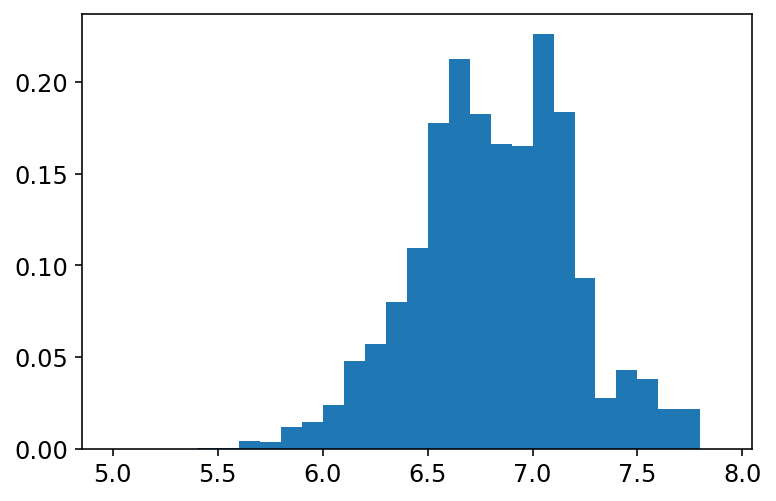

In [7]:
plt.hist(np.log10(prim_e_numu),weights=weight_numu_astro,bins=np.arange(5,8,0.1))
plt.show()

In [8]:
print(np.sum(weight_numu_astro))

1.9187833842889077


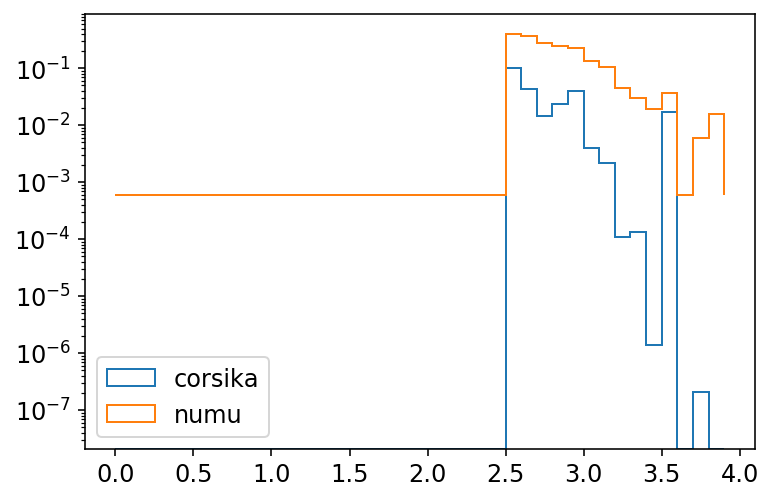

In [9]:
plt.hist(np.log10(chi2_red_new_corsika),weights=weight_corsika,histtype='step',log=True,bins=np.arange(0,4,0.1),label='corsika')
plt.hist(np.log10(chi2_red_new_numu),weights=weight_numu_astro,histtype='step',log=True,bins=np.arange(0,4,0.1),label='numu')
plt.legend()
plt.show()

In [10]:
# effective area 
areas =  OneWeight/(n_file * NEvents) * 2 # or: 1./gen * p_int / n_file / unit . Each flavor, neutrino or antineutrino only! 
neutrino_energy_my = np.logspace(2, 8, 100)
binwidth = 4*np.pi*np.diff(neutrino_energy_my)
effective_area_numu_my = np.histogram(prim_e_numu, weights=areas, bins=neutrino_energy_my)[0]/binwidth / 1e4 # cm^2 to m^2
neutrino_energy_my = (neutrino_energy_my[1:]+neutrino_energy_my[:-1])/2

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


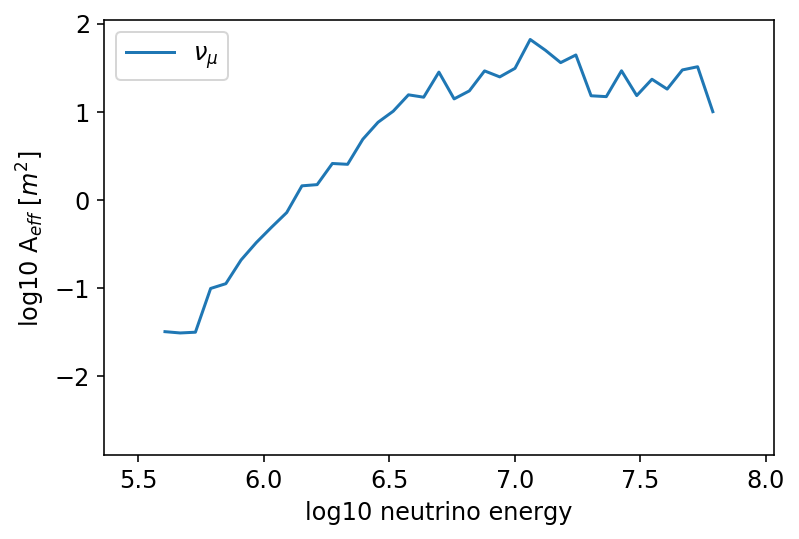

In [11]:
plt.plot(np.log10(neutrino_energy_my),np.log10(effective_area_numu_my),label=r'$\nu_{\mu}$')
plt.xlabel('log10 neutrino energy')
plt.ylabel(r'log10 A$_{eff}$ [$m^2$] ') # numu, or numubar only
plt.legend()
plt.show()

In [12]:
N = 10
energy_bin = np.linspace(5.5,7.5,N)
zenith_bin = np.linspace(0,1,N)

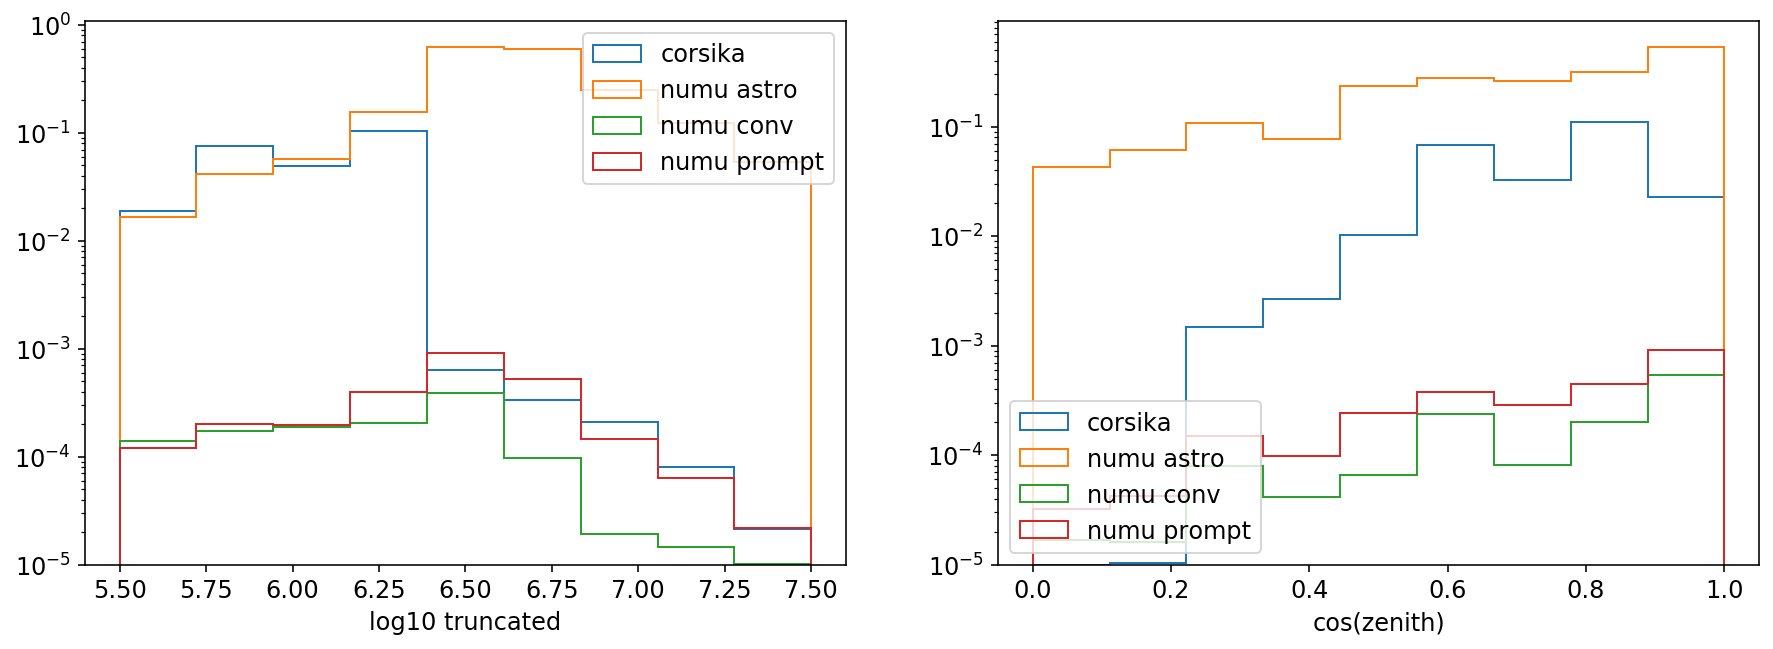

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(np.log10(truncated_muon_e_corsika),weights=weight_corsika,bins=energy_bin,histtype='step',label='corsika',log=True,bottom=1e-5)
plt.hist(np.log10(truncated_muon_e_numu),weights=weight_numu_astro,bins=energy_bin,histtype='step',label='numu astro',log=True,bottom=1e-5)
plt.hist(np.log10(truncated_muon_e_numu),weights=weight_numu_conv,bins=energy_bin,histtype='step',label='numu conv',log=True,bottom=1e-5)
plt.hist(np.log10(truncated_muon_e_numu),weights=weight_numu_prompt,bins=energy_bin,histtype='step',label='numu prompt',log=True,bottom=1e-5)

plt.legend()
plt.xlabel('log10 truncated')
plt.subplot(122)
plt.hist(np.cos(zenith_corsika),weights=weight_corsika,bins=zenith_bin,histtype='step',label='corsika',log=True,bottom=1e-5)
plt.hist(np.cos(zenith_numu),weights=weight_numu_astro,bins=zenith_bin,histtype='step',label='numu astro',log=True,bottom=1e-5)
plt.hist(np.cos(zenith_numu),weights=weight_numu_conv,bins=zenith_bin,histtype='step',label='numu conv',log=True,bottom=1e-5)
plt.hist(np.cos(zenith_numu),weights=weight_numu_prompt,bins=zenith_bin,histtype='step',label='numu prompt',log=True,bottom=1e-5)

plt.legend(loc='lower left')
plt.xlabel('cos(zenith)')
plt.show()

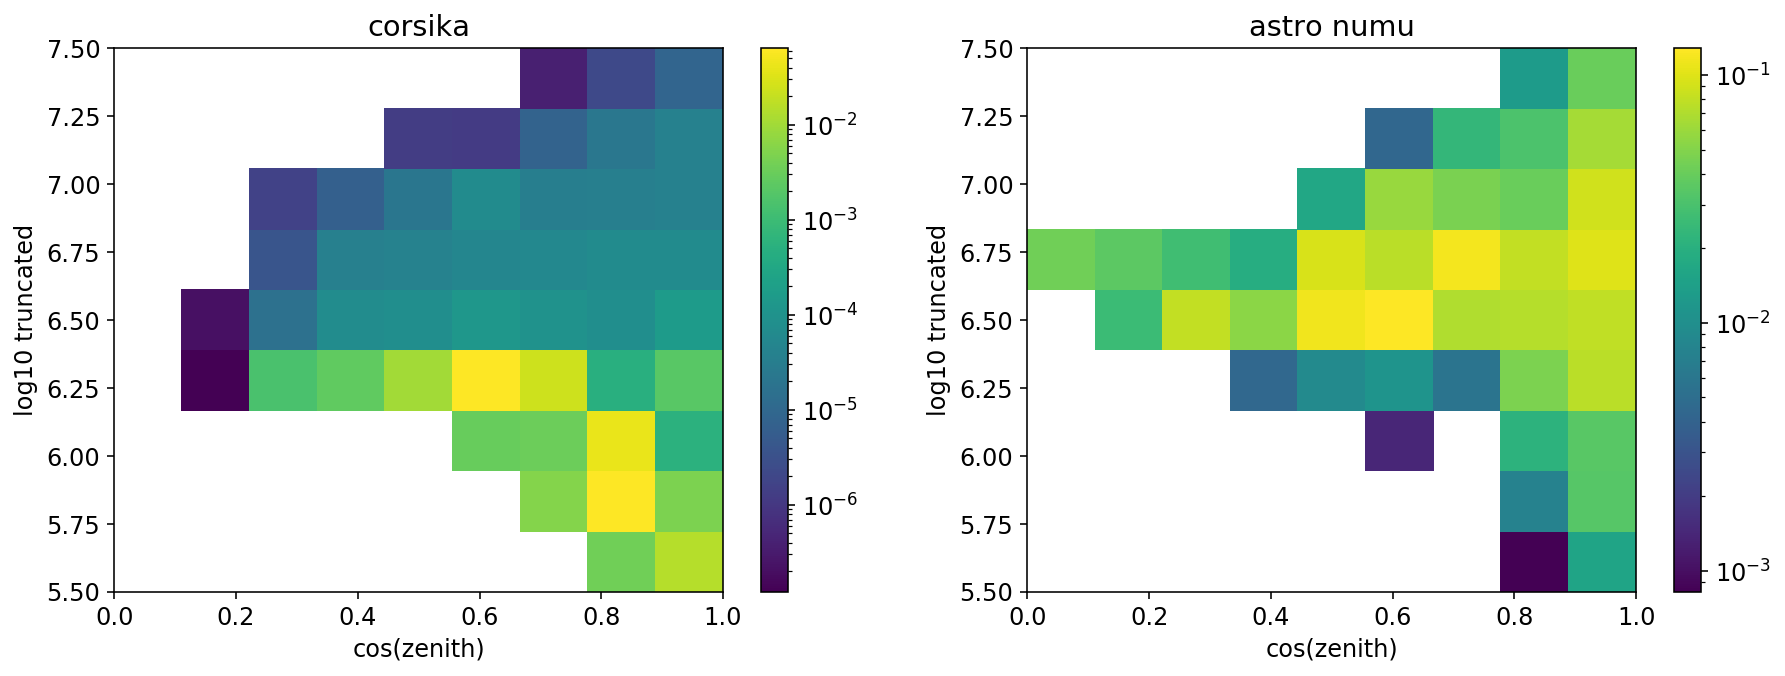

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist2d(np.cos(zenith_corsika),np.log10(truncated_muon_e_corsika),weights=weight_corsika,bins=[zenith_bin,energy_bin],norm=matplotlib.colors.LogNorm())
plt.xlabel('cos(zenith)')
plt.ylabel('log10 truncated')
plt.title('corsika')
plt.colorbar()
plt.subplot(122)
plt.hist2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=weight_numu_astro,bins=[zenith_bin,energy_bin],norm=matplotlib.colors.LogNorm())
plt.xlabel('cos(zenith)')
plt.ylabel('log10 truncated')
plt.title('astro numu')
plt.colorbar()
plt.show()

# Reading Aeff

In [15]:
new_hese_dir='/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/effective_areas_txt/'
neutrino_energy,eff_area_hese_numu = np.loadtxt(new_hese_dir+'eff_area_hese_numu.txt',unpack=True)
_,eff_area_hese_numubar = np.loadtxt(new_hese_dir +'eff_area_hese_numubar.txt',unpack=True)
_,eff_area_hese_nue = np.loadtxt(new_hese_dir +'eff_area_hese_nue.txt',unpack=True)
_,eff_area_hese_nuebar = np.loadtxt(new_hese_dir +'eff_area_hese_nuebar.txt',unpack=True)
_,eff_area_hese_nutau = np.loadtxt(new_hese_dir +'eff_area_hese_nutau.txt',unpack=True)
_,eff_area_hese_nutaubar = np.loadtxt(new_hese_dir +'eff_area_hese_nutaubar.txt',unpack=True)

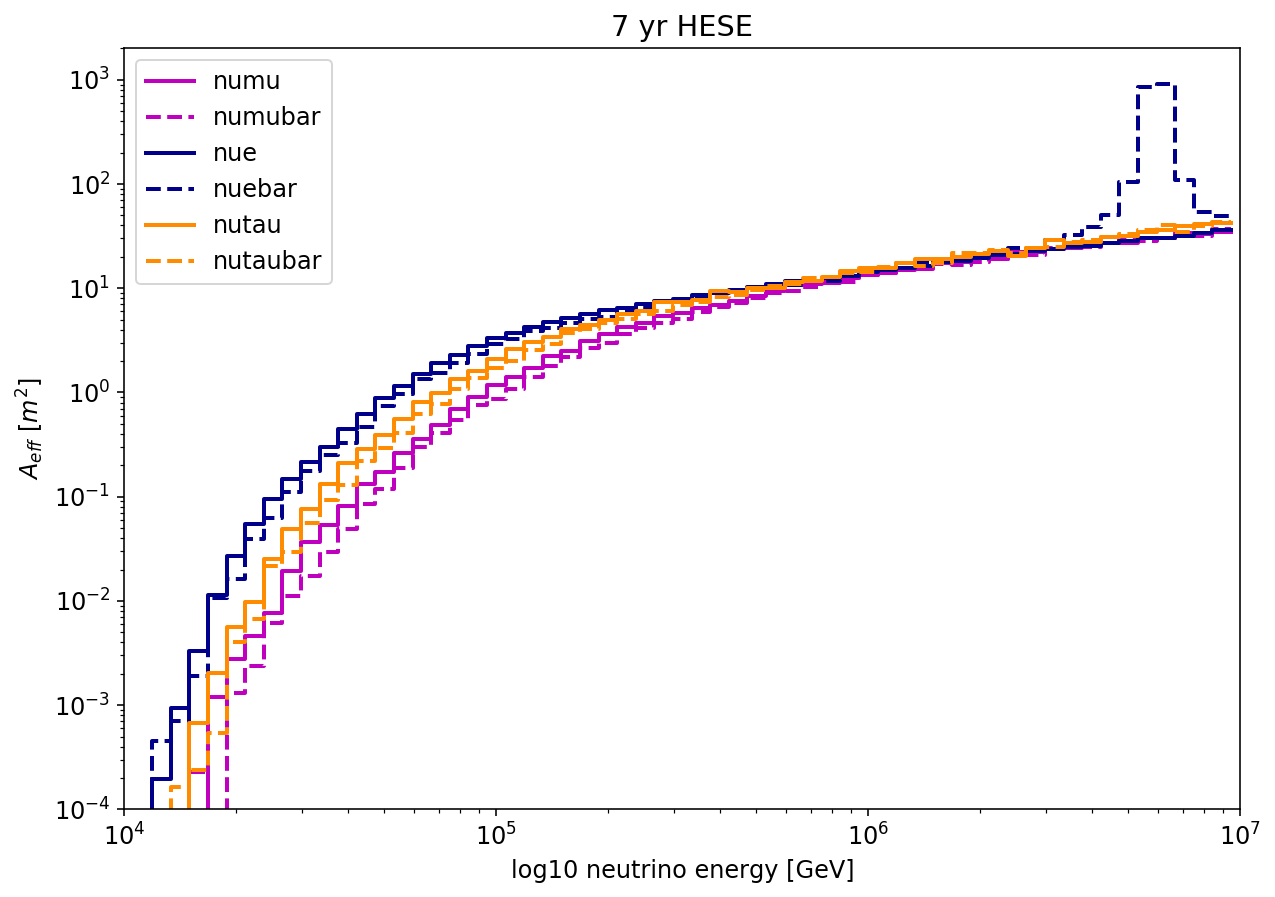

In [16]:
fig,ax=plt.subplots(figsize=(10,7))
plt.step(neutrino_energy,eff_area_hese_numu,lw=2,label='numu',color='m')
plt.step(neutrino_energy,eff_area_hese_numubar,'--',lw=2,label='numubar',color='m')
plt.step(neutrino_energy,eff_area_hese_nue,lw=2,label='nue',color='darkblue')
plt.step(neutrino_energy,eff_area_hese_nuebar,'--',lw=2,label='nuebar',color='darkblue')
plt.step(neutrino_energy,eff_area_hese_nutau,lw=2,label='nutau',color='darkorange')
plt.step(neutrino_energy,eff_area_hese_nutaubar,'--',lw=2,label='nutaubar',color='darkorange')
plt.xlabel('log10 neutrino energy [GeV]')
plt.ylabel(r'$A_{eff}$ [$m^2$]')
plt.title('7 yr HESE')
plt.legend()

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim((1e4, 1e7))
ax.set_ylim((1e-4, 2e3))
plt.show()

In [17]:
Livetime = 86400*365*8

enBin       = np.logspace(4,8,26)   # [10TeV, 100PeV]

lBinEdge    = enBin[:-1]                # left bin edge
rBinEdge    = enBin[1:]                 # right bin edge
enBinCent   = np.sqrt( enBin[:-1] * enBin[1:] )  # geometric mean, log(bincent) = 1/2(log(left)+log(right))
nPts        = enBinCent.size

In [18]:
def getAeffInterp(energy, eff_area_per_type): # get eff area values [cm^2] at certain energy values (dA/dE)

    # Values extrapolated out of the original range are set to zero.
    InterpAeff = interp1d(energy, eff_area_per_type, bounds_error = False, fill_value = 0. )

    # Aeff is in m^2, while fluxes are in cm^2, so multiply by 1.e4 to
    # covert.  NOTE:  THE EFFECTIVE AREAS ARE NOT ADDED, SO _NO_ DIVISION BY
    # 2 FOR PER TYPE
    ##### !!!!! correction, they were added so /2 is needed!  ????????????????
    effArea = 1e4 * InterpAeff(enBinCent) # get vals at enBinCent

    return effArea

In [19]:
# get eff area values [cm^2] at enBinCent locations

# HESE
AeffNuMuHESE    = getAeffInterp(neutrino_energy,eff_area_hese_numu)
AeffNuMuBarHESE    = getAeffInterp(neutrino_energy,eff_area_hese_numubar)
AeffNuEHESE    = getAeffInterp(neutrino_energy,eff_area_hese_nue)
AeffNuEBarHESE    = getAeffInterp(neutrino_energy,eff_area_hese_nuebar)
AeffNuTauHESE    = getAeffInterp(neutrino_energy,eff_area_hese_nutau)
AeffNuTauBarHESE    = getAeffInterp(neutrino_energy,eff_area_hese_nutaubar)

# myown
AeffNuMuMY   = getAeffInterp(neutrino_energy_my,effective_area_numu_my) # should be both nu + nubar
# AeffNuMuBarMY   = getAeffInterp(neutrino_energy_my,effective_area_numubar_my)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


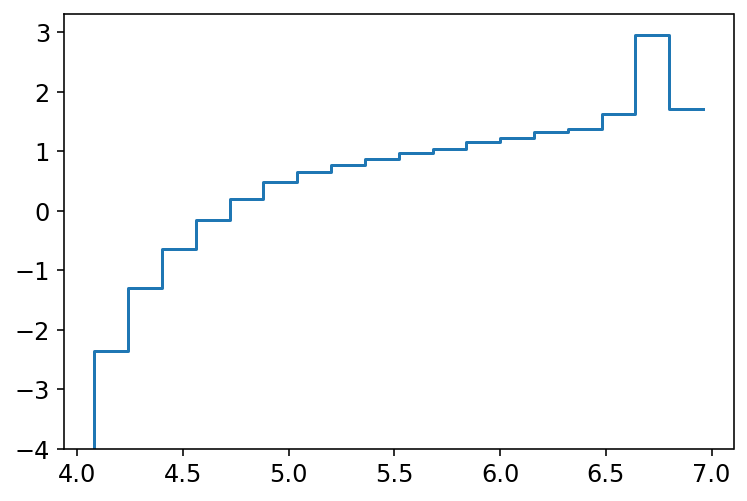

In [20]:
plt.step(np.log10(enBinCent),np.log10(AeffNuEBarHESE/1e4))
plt.ylim(-4,)
plt.show()

In [21]:
# return flux per energy bin, [1/GeV/s/sr/cm^2] 
# Note the unit of flux itself is [1/GeV/s/sr/cm^2], but it depends on energy: phi = phi(E).
# need to sum over phi: integral(phi(E)dE) in each bins to discretize, then return flux in each energy bin. 

def astroFlux( fluxNormMult, specIdx, energyCut): 

    avgAstroFlux = np.zeros(nPts, dtype = np.float64 )

    for i, (loLim, upLim) in enumerate(zip(lBinEdge, rBinEdge)):
        avgAstroFlux[i] = fluxNormMult * 1e-18 * quad( lambda E: \
                             (E/1e5)**(-specIdx) * np.exp(-E/energyCut),
                             loLim, upLim )[0]
#     avgAstroFlux = fluxNormMult * 1e-18 * (enBinCent/1e5)**(-specIdx) * np.exp(-enBinCent/energyCut)
    return avgAstroFlux

In [22]:
# dN/dE, number of events in certain energy bins. 
# dN/dE = flux(dPhi/dE for each energy bin) * solid_angle * Aeff(at each energy) * time
def dNobs( dNdEAstro, Aeff, Livetime ): # should have conv and prompt, but ignore for now
    dNobsAstro   = 4 * np.pi * Aeff * dNdEAstro * Livetime
    dNobs = dNobsAstro.copy() # + conv and prompt
    return dNobs

In [23]:
def dNObsBreakDown( dNdEAstro, Aeff, Livetime ): # return total and each contribution
    dNobsAstro   = 4 * np.pi * Aeff * dNdEAstro * Livetime
    dNobs =  dNobsAstro.copy()
    return dNobs, dNobsAstro

In [80]:
# 1. HESE
GenAstroFlux = astroFlux(fluxNormMult = 6.37,specIdx = 2.87,energyCut = np.inf) # 'observed' HESE flux

dNObsNuMuHESE, dNObsAstroNuMuHESE = dNObsBreakDown(GenAstroFlux, AeffNuMuHESE, Livetime)
dNObsNuMuBarHESE, dNObsAstroNuMuBarHESE = dNObsBreakDown(GenAstroFlux, AeffNuMuBarHESE, Livetime)
dNObsNuEHESE, dNObsAstroNuEHESE = dNObsBreakDown(GenAstroFlux, AeffNuEHESE, Livetime)
dNObsNuEBarHESE, dNObsAstroNuEBarHESE = dNObsBreakDown(GenAstroFlux, AeffNuEBarHESE, Livetime)
dNObsNuTauHESE, dNObsAstroNuTauHESE = dNObsBreakDown(GenAstroFlux, AeffNuTauHESE, Livetime)
dNObsNuTauBarHESE, dNObsAstroNuTauBarHESE = dNObsBreakDown(GenAstroFlux, AeffNuTauBarHESE, Livetime)

# total observed HESE
dNObsTotHESE = dNObsNuMuHESE +\
                dNObsNuMuBarHESE +\
                dNObsNuEHESE +\
                dNObsNuEBarHESE +\
                dNObsNuTauHESE +\
                dNObsNuTauBarHESE

# sub: total observed astro
dNObsAstroHESE = dNObsAstroNuMuHESE +\
                dNObsAstroNuMuBarHESE +\
                dNObsAstroNuEHESE +\
                dNObsAstroNuEBarHESE +\
                dNObsAstroNuTauHESE +\
                dNObsAstroNuTauBarHESE

# 2. myown
GenAstroFlux_MY = astroFlux(fluxNormMult = 6.7/3,specIdx = 2,energyCut = np.inf) # 'observed' diffuse flux
# sub: 
dNObsNuMuMY, dNObsAstroNuMuMY = dNObsBreakDown(GenAstroFlux_MY, AeffNuMuMY, Livetime) # UNIT???
dNObsNuMuBarMY, dNObsAstroNuMuBarMY = dNObsBreakDown(GenAstroFlux_MY, AeffNuMuMY, Livetime) # UNIT???

# # UNIT???
# dNObsNuMuMY /= 1e4
# dNObsAstroNuMuMY /= 1e4

# 3. total 
dNObsTot = dNObsTotHESE + dNObsNuMuMY
print(np.sum(dNObsTotHESE),np.sum(dNObsNuMuMY))
# sub: 
# dNObsAstroTot = ... 

487.95663117324625 5.751633483343192


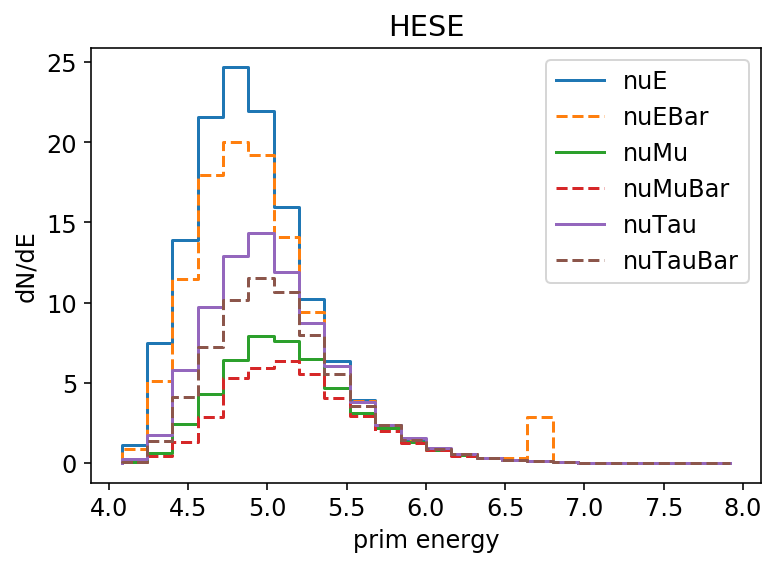

In [81]:
plt.step(np.log10(enBinCent),dNObsNuEHESE,label='nuE')
plt.step(np.log10(enBinCent),dNObsNuEBarHESE,'--',label='nuEBar')

plt.step(np.log10(enBinCent),dNObsNuMuHESE,label='nuMu')
plt.step(np.log10(enBinCent),dNObsNuMuBarHESE,'--',label='nuMuBar')

plt.step(np.log10(enBinCent),dNObsNuTauHESE,label='nuTau')
plt.step(np.log10(enBinCent),dNObsNuTauBarHESE,'--',label='nuTauBar')
plt.legend()
plt.title('HESE')
plt.xlabel('prim energy')
plt.ylabel('dN/dE')
plt.show()

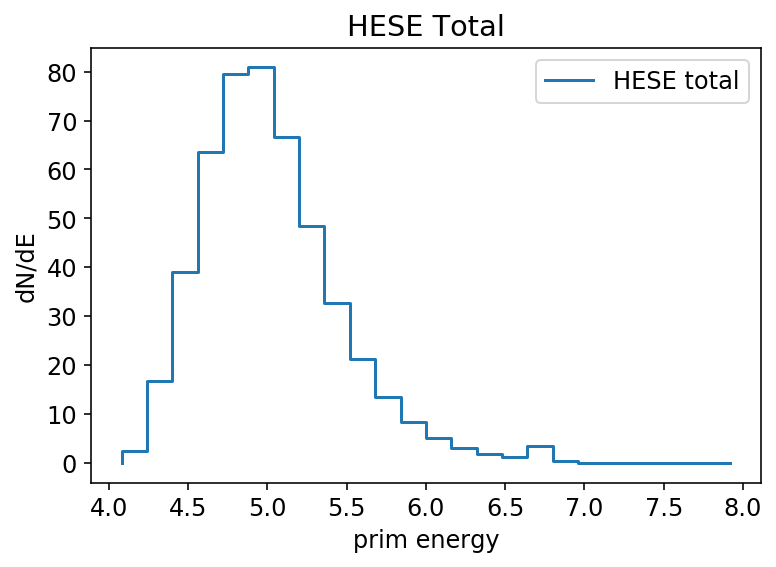

In [82]:
plt.step(np.log10(enBinCent),dNObsTotHESE,label='HESE total')
plt.legend()
plt.title('HESE Total')
plt.xlabel('prim energy')
plt.ylabel('dN/dE')
plt.show()

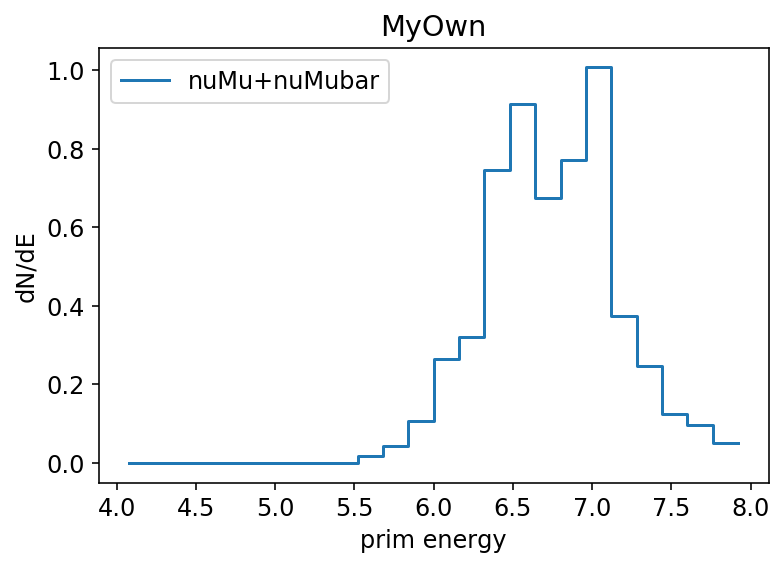

In [83]:
plt.step(np.log10(enBinCent),dNObsNuMuMY,label='nuMu+nuMubar')
plt.legend()
plt.title('MyOwn')
plt.xlabel('prim energy')
plt.ylabel('dN/dE')
plt.show()

In [84]:
print(np.sum(dNObsNuMuMY))

5.751633483343192


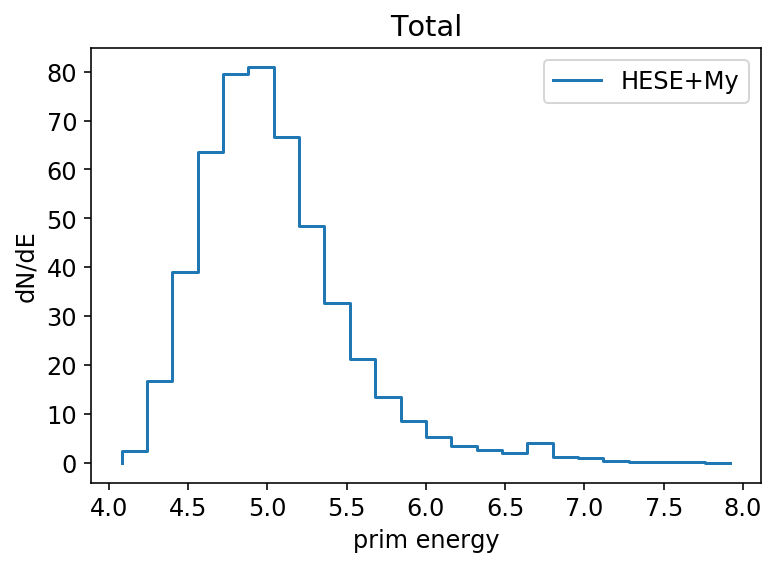

In [85]:
plt.step(np.log10(enBinCent),dNObsTot,label='HESE+My')
plt.legend()
plt.title('Total')
plt.xlabel('prim energy')
plt.ylabel('dN/dE')
plt.show()

In [86]:
print("****** HESE Sample ********* " )
print("****** dNObsTotHESE ******** = " + str(np.sum(dNObsTotHESE)))

print("****** dNObsNuEHESE ******** = " + str(np.sum(dNObsNuEHESE)))
print("****** dNObsNuEBarHESE ******** = " + str(np.sum(dNObsNuEBarHESE)))

print(" E % = " + str (  (np.sum(dNObsNuEHESE) +  np.sum(dNObsNuEBarHESE))*100/(np.sum(dNObsTotHESE)) ) )


print("****** dNObsAstroHESE ********* = " + str(np.sum(dNObsAstroHESE)))
print("****** dNObsAstroHESE E + EBar ********* = " + str(np.sum(dNObsNuEHESE) + np.sum(dNObsNuEBarHESE)))


****** HESE Sample ********* 
****** dNObsTotHESE ******** = 487.95663117324625
****** dNObsNuEHESE ******** = 132.91747548787782
****** dNObsNuEBarHESE ******** = 116.77928725853245
 E % = 51.171917091491856
****** dNObsAstroHESE ********* = 487.95663117324625
****** dNObsAstroHESE E + EBar ********* = 249.6967627464103


## 1. HESE only; norm vs. gamma; data: no cutoff, model: no cutoff

In [87]:
def llh(norm, gamma, cutoff): # data: no cutoff
    astroFluxArrPredicted = astroFlux(norm,gamma,10**cutoff) # varying flux 
    
    dNPredNuMu = dNobs(astroFluxArrPredicted, AeffNuMuHESE, Livetime)
    dNPredNuMuBar = dNobs(astroFluxArrPredicted, AeffNuMuBarHESE, Livetime)
    dNPredNuE = dNobs(astroFluxArrPredicted, AeffNuEHESE, Livetime)
    dNPredNuEBar = dNobs(astroFluxArrPredicted, AeffNuEBarHESE, Livetime)
    dNPredNuTau = dNobs(astroFluxArrPredicted, AeffNuTauHESE, Livetime)
    dNPredNuTauBar = dNobs(astroFluxArrPredicted, AeffNuTauBarHESE, Livetime)
    
    dNPredTotHESE = dNPredNuMu +\
                    dNPredNuMuBar +\
                    dNPredNuE +\
                    dNPredNuEBar +\
                    dNPredNuTau +\
                    dNPredNuTauBar
    
    # calculating log likelihood using Sterling approx
    
    llh = np.where(dNObsTotHESE > 0, 
                   dNObsTotHESE*np.log(dNPredTotHESE)-dNPredTotHESE-(dNObsTotHESE*np.log(dNObsTotHESE)-dNObsTotHESE),
                   -dNPredTotHESE)
    llh = np.sum(llh)
    return llh

def negllh(norm, gamma, cutoff):
    return -llh(norm, gamma, cutoff)

In [88]:
NBins = 100 # Number of bins used in scan, each dimension

In [89]:
m = mi.Minuit(negllh,
              norm=6.,gamma=2.9,cutoff=np.inf,
              limit_norm=(0.01,10),limit_gamma=(1.5,3.5),limit_cutoff=None,
              fix_norm=False,fix_gamma=False,fix_cutoff=True,
              errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
             )

In [90]:
m.migrad()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


------------------------------------------------------------------
| FCN = 1.844e-07               |      Ncalls=36 (36 total)      |
| EDM = 1.84e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | norm   |   6.37    |   0.29    |            |            |  0.01   |   10    |       |
| 1 | gamma  |   2.87    |   0.04    |            |            |   1.5   |   3.5   |       |
| 2 | cutoff |    inf    |    inf    |            |            |         |         |  yes  |
--------------------------------------------------------------------------------------------

In [91]:
llh_best = llh(m.values[0],m.values[1],m.values[2])

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


In [92]:
# 2d scan
norms = np.linspace(0.01,10,NBins) # norm
gammas = np.linspace(1.5,3.5,NBins) # gamma
ns = []
gs = []
ls = []
for i in range(0,len(norms)):
    for j in range(0,len(gammas)):
        ns.append(norms[i])
        gs.append(gammas[j])
        m_tmp = mi.Minuit(negllh,
                          norm=norms[i],gamma=gammas[j],cutoff=np.inf,
                          limit_norm=None,limit_gamma=None,limit_cutoff=None,
                          fix_norm=True,fix_gamma=True,fix_cutoff=True,
                          errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                         )
        m_tmp.migrad()
        ls.append(llh(norms[i],gammas[j],np.inf))
ls = np.array(ls)
t = -2 * (ls - llh_best) # -2 ln (L/L_best_estimate)

# 1d scan 
nns,nnprof,_ = m.mnprofile("norm",bound=(0.01,10),bins=NBins)
nnprof = -2 * (-nnprof - llh_best)

ggs,ggprof,_ = m.mnprofile("gamma",bound=(1.5,3.5),bins=NBins)
ggprof = -2 * (-ggprof - llh_best)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


In [93]:
CL = [2.3, 6.0, 9.21] # chi2 distribution of 2 dof, Confidence Intervals

# path of best fits
best_norms = []
for i in range(0,len(gammas)):
    m_tmp = mi.Minuit(negllh,
                      norm=1,gamma=gammas[i],cutoff=np.inf,
                      limit_norm=(0.01,10),limit_gamma=(1.5,3.5),limit_cutoff=None,
                      fix_norm=False,fix_gamma=True,fix_cutoff=True,
                      errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                     )
    m_tmp.migrad()
    best_norms.append(m_tmp.values[0])

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


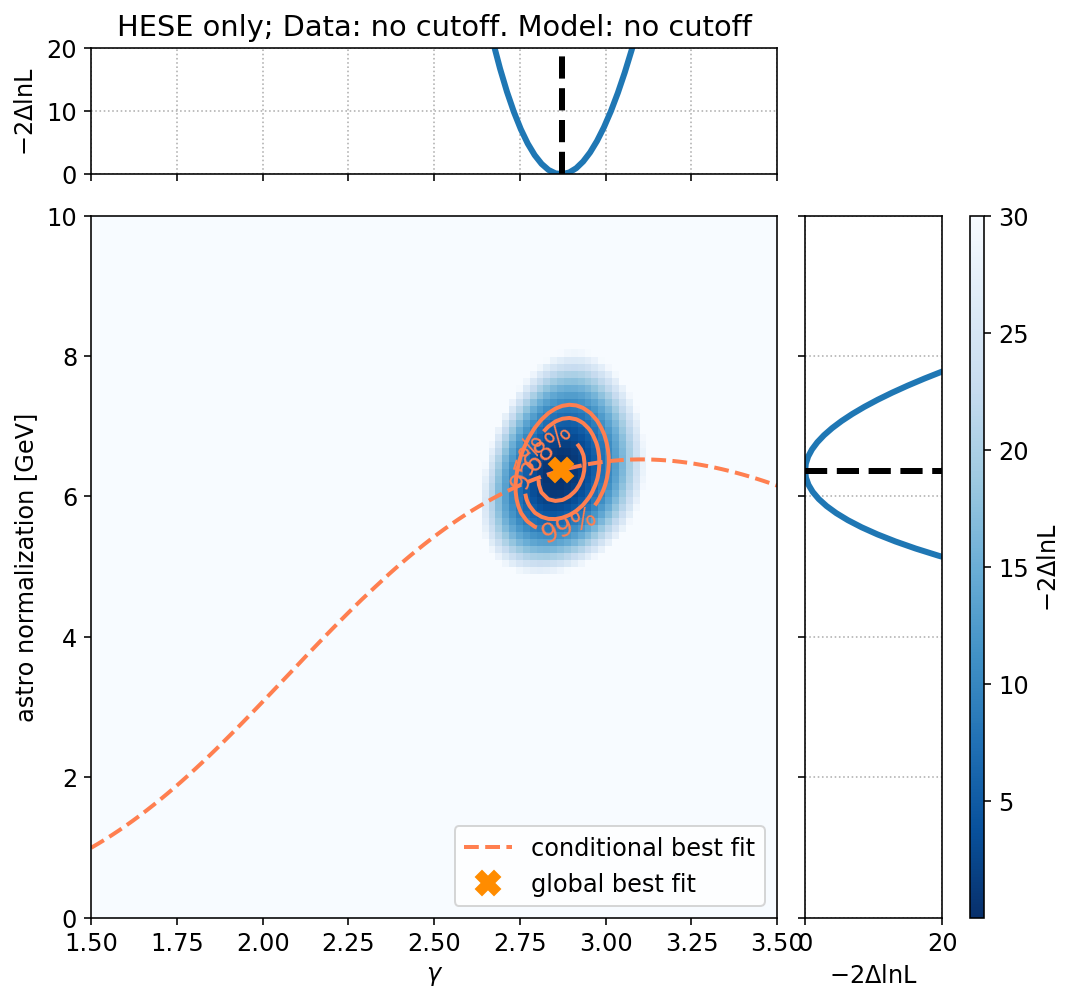

In [94]:
plt.figure(figsize=(8,8))

gspec = gridspec.GridSpec(2, 3,width_ratios=[5,1,0.1], height_ratios=[0.9,5], wspace=0.1, hspace=0.1)

ax1 = plt.subplot(gspec[0])

plt.plot(ggs,ggprof,lw=3)
plt.axvline(ggs[ggprof==np.min(ggprof)],ls='--',lw=3,color='black')
plt.xlim(1.5,3.5)
plt.ylim(0,20)
plt.ylabel(r'$-2\Delta$lnL')
plt.title('HESE only; Data: no cutoff. Model: no cutoff')
ax1.tick_params(labelbottom=False)    
plt.grid(True,which='both',zorder=0,linestyle=':')
axbar = plt.subplot(gspec[5])

ax2 = plt.subplot(gspec[3])

h,yy,xx,img=plt.hist2d(gs,ns,weights=t.clip(-np.inf,30),bins=[len(gammas),len(norms)],range=[[1.5,3.5],[0,10]],cmap='Blues_r')#,norm=LogNorm())
plt.plot(gammas,best_norms,'--',color='coral',lw=2,label='conditional best fit')
plt.plot(m.values[1],m.values[0],'X',color='darkorange',ms=12,label='global best fit')
cbar = plt.colorbar(cax=axbar)
cbar.set_label(r'$-2\Delta$lnL') 
CS=plt.contour(h.transpose(),extent=[np.min(gammas),np.max(gammas),np.min(norms),np.max(norms)],levels=CL,colors='coral',linewidths=2)
plt.clabel(CS,fmt={CL[0]:'68%',CL[1]:'95%',CL[2]:'99%'},fontsize=13)
plt.legend(loc='lower right',prop={'size': 12})
plt.xlim(1.5,3.5)
plt.ylim(0,10)
plt.xlabel(r'$\gamma$')
plt.ylabel('astro normalization [GeV]')

ax3 = plt.subplot(gspec[4])

plt.plot(nnprof,nns,lw=3)
plt.axhline(nns[nnprof==np.min(nnprof)],ls='--',lw=3,color='black')
ax3.tick_params(labelleft=False)
plt.xlim(0,20)
plt.ylim(0,10)
plt.xlabel(r'$-2\Delta$lnL')
plt.grid(True,which='both',zorder=0,linestyle=':')

plt.show()

## 2. HESE only; cutoff vs. gamma; data: no cutoff, model: cutoff

In [95]:
m = mi.Minuit(negllh,
              norm=6.37,gamma=2.87,cutoff=7.,
              limit_norm=(0.01,10),limit_gamma=(1.5,3.5),limit_cutoff=(6,7.5),
              fix_norm=False,fix_gamma=False,fix_cutoff=False,
              error_norm=0.125,error_gamma=0.25,error_cutoff=0.1,
              errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
             )

In [96]:
m.migrad()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


------------------------------------------------------------------
| FCN = 0.05704                 |      Ncalls=92 (92 total)      |
| EDM = 1.84e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | norm   |    6.4    |    0.3    |            |            |  0.01   |   10    |       |
| 1 | gamma  |   2.86    |   0.05    |            |            |   1.5   |   3.5   |       |
| 2 | cutoff |    7.5    |    1.4    |            |            |    6    |   7.5   |       |
--------------------------------------------------------------------------------------------

In [97]:
llh_best = llh(m.values[0],m.values[1],m.values[2])

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


In [98]:
# 2d scan
gammas = np.linspace(1.5,3.5,NBins) # gamma
cutoffs = np.linspace(6,7.5,NBins) # cutoff
cs = []
gs = []
ls = []
for i in range(0,len(gammas)):
    for j in range(0,len(cutoffs)):
        gs.append(gammas[i])
        cs.append(cutoffs[j])
        m_tmp = mi.Minuit(negllh,
                          norm=6.,gamma=gammas[i],cutoff=cutoffs[j],
                          limit_norm=(0.01,10),limit_gamma=(1.5,3.5),limit_cutoff=(6,7.5),
                          fix_norm=False,fix_gamma=True,fix_cutoff=True,
                          errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                         )
        m_tmp.migrad()
        ls.append(llh(m_tmp.values[0],gammas[i],cutoffs[j]))
ls = np.array(ls)
t = -2 * (ls - llh_best) # -2 ln (L/L_best_estimate)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


In [99]:
# 1d scan 
ggs,ggprof,_ = m.mnprofile("gamma",bound=(1.5,3.5),bins=NBins)
ggprof = -2 * (-ggprof - llh_best)

ccs,ccprof,_ = m.mnprofile("cutoff",bound=(6,7.5),bins=NBins)
ccprof = -2 * (-ccprof - llh_best)

# path of best fits
best_cutoffs = []
for i in range(0,len(gammas)):
    m_tmp = mi.Minuit(negllh,
                      norm=6,gamma=gammas[i],cutoff=7,
                      limit_norm=(0.01,10),limit_gamma=(1.5,3.5),limit_cutoff=(6,7.5),
                      fix_norm=False,fix_gamma=True,fix_cutoff=False,
                      errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                     )
    m_tmp.migrad()
    best_cutoffs.append(m_tmp.values[2])

CL = [2.3, 6.0, 9.21] # chi2 distribution of 2 dof, Confidence Intervals

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


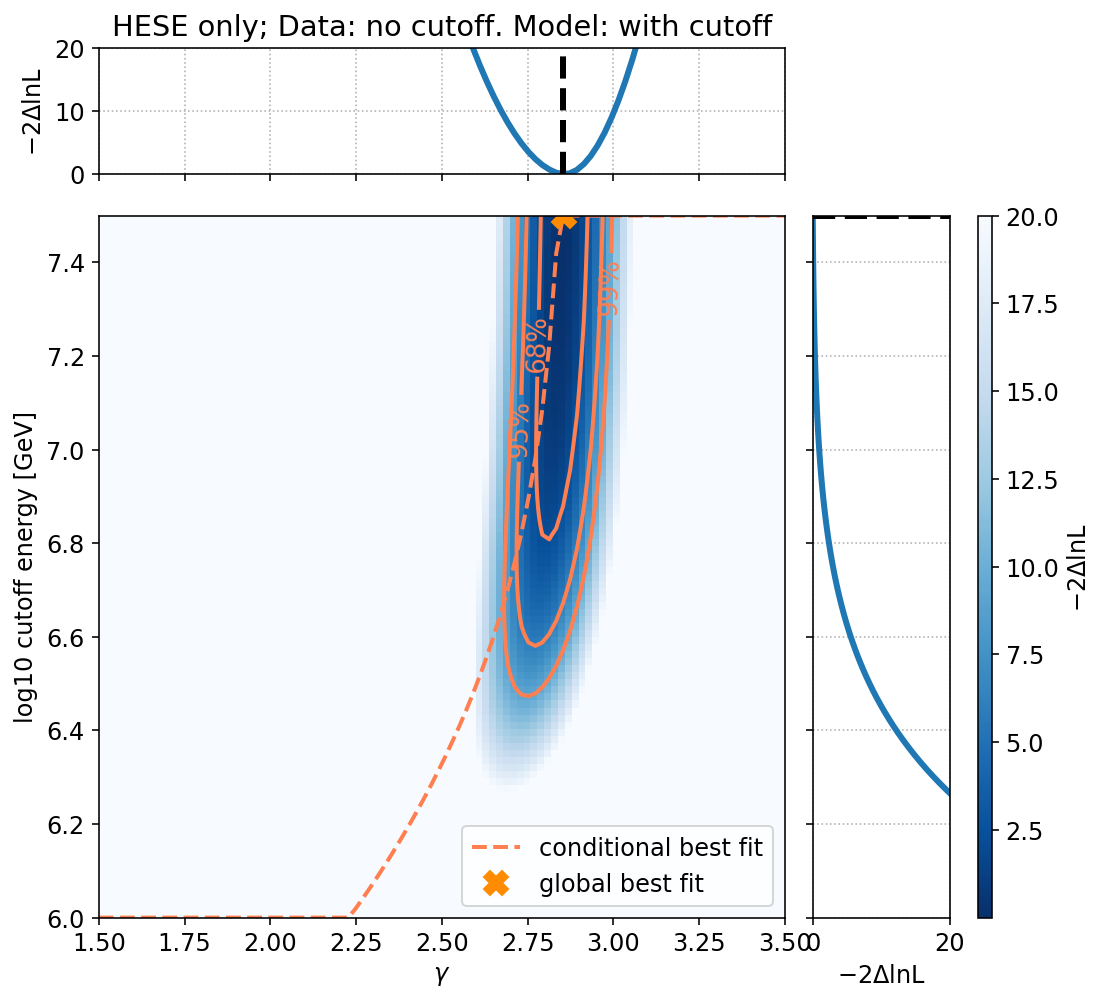

In [100]:
plt.figure(figsize=(8,8))

gspec = gridspec.GridSpec(2, 3,width_ratios=[5,1,0.1], height_ratios=[0.9,5], wspace=0.1, hspace=0.1)

ax1 = plt.subplot(gspec[0])

plt.plot(ggs,ggprof,lw=3)
plt.axvline(ggs[ggprof==np.min(ggprof)],ls='--',lw=3,color='black')
plt.xlim(1.5,3.5)
plt.ylim(0,20)
plt.ylabel(r'$-2\Delta$lnL')
plt.title('HESE only; Data: no cutoff. Model: with cutoff')
ax1.tick_params(labelbottom=False)    
plt.grid(True,which='both',zorder=0,linestyle=':')

axbar = plt.subplot(gspec[5])

ax2 = plt.subplot(gspec[3])

h,yy,xx,img=plt.hist2d(gs,cs,weights=t.clip(-np.inf,20),bins=[len(gammas),len(cutoffs)],range=[[1.5,3.5],[6,7.5]],cmap='Blues_r')#,norm=LogNorm())
plt.plot(gammas,best_cutoffs,'--',color='coral',lw=2,label='conditional best fit')
plt.plot(m.values[1],m.values[2],'X',color='darkorange',ms=12,label='global best fit')
cbar = plt.colorbar(cax=axbar)
cbar.set_label(r'$-2\Delta$lnL') 
CS=plt.contour(h.transpose(),extent=[np.min(gammas),np.max(gammas),np.min(cutoffs),np.max(cutoffs)],levels=CL,colors='coral',linewidths=2)
plt.clabel(CS,fmt={CL[0]:'68%',CL[1]:'95%',CL[2]:'99%'},fontsize=13)
plt.legend(loc='lower right',prop={'size': 12})
plt.xlim(1.5,3.5)
plt.ylim(6,7.5)
plt.xlabel(r'$\gamma$')
plt.ylabel('log10 cutoff energy [GeV]')

ax3 = plt.subplot(gspec[4])

plt.plot(ccprof,ccs,lw=3)
plt.axhline(ccs[ccprof==np.min(ccprof)],ls='--',lw=3,color='black')
ax3.tick_params(labelleft=False)
plt.xlim(0,20)
plt.ylim(6,7.5)
plt.xlabel(r'$-2\Delta$lnL')
plt.grid(True,which='both',zorder=0,linestyle=':')

plt.show()

In [101]:
ccprof_before = ccprof.copy()
ggprof_before = ggprof.copy()
ccs_before = ccs.copy()
ggs_before = ggs.copy()

In [102]:
gamma_68_before,cutoff_68_before = CS.allsegs[0][0][:,0],CS.allsegs[0][0][:,1]
gamma_95_before,cutoff_95_before = CS.allsegs[1][0][:,0],CS.allsegs[1][0][:,1]

In [103]:
m_before = m

### 2.5 Try MCMC

In [51]:
import emcee
import corner

In [106]:
def llh_mcmc(x): # data: no cutoff
    norm, gamma, log_cutoff = x
    if norm<0:
        return -np.inf
    if log_cutoff > 8 or log_cutoff < 6:
        return -np.inf
    
    astroFluxArrPredicted = astroFlux(norm,gamma,10**log_cutoff) # varying flux # NOTE: Passing in log(E_cut)
    
    dNPredNuMu = dNobs(astroFluxArrPredicted, AeffNuMuHESE, Livetime)
    dNPredNuMuBar = dNobs(astroFluxArrPredicted, AeffNuMuBarHESE, Livetime)
    dNPredNuE = dNobs(astroFluxArrPredicted, AeffNuEHESE, Livetime)
    dNPredNuEBar = dNobs(astroFluxArrPredicted, AeffNuEBarHESE, Livetime)
    dNPredNuTau = dNobs(astroFluxArrPredicted, AeffNuTauHESE, Livetime)
    dNPredNuTauBar = dNobs(astroFluxArrPredicted, AeffNuTauBarHESE, Livetime)
    
    dNPredTotHESE = dNPredNuMu +\
                    dNPredNuMuBar +\
                    dNPredNuE +\
                    dNPredNuEBar +\
                    dNPredNuTau +\
                    dNPredNuTauBar
    
    # calculating log likelihood using Sterling approx
    llh = np.where(dNObsTotHESE > 0, 
                   dNObsTotHESE*np.log(dNPredTotHESE)-dNPredTotHESE-(dNObsTotHESE*np.log(dNObsTotHESE)-dNObsTotHESE),
                   -dNPredTotHESE)
    llh = np.sum(llh)
    return llh


In [107]:
pos = [6.37,2.87,7.5] + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

In [108]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, llh_mcmc)
sampler.run_mcmc(pos, 50000, progress=True);

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply
100%|██████████| 50000/50000 [31:25<00:00, 26.51it/s]


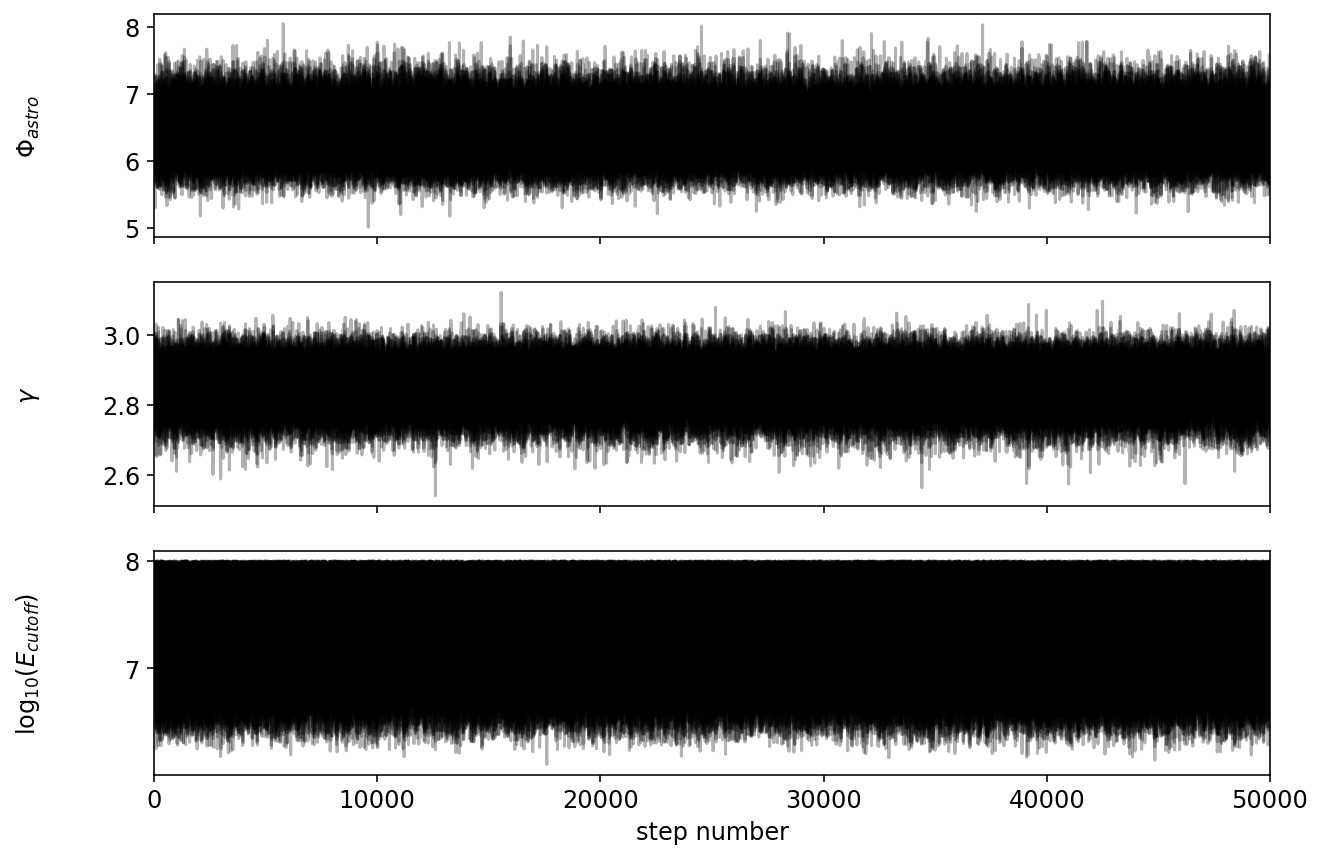

In [109]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Phi_{astro}$", r"$\gamma$", r"$\log_{10}(E_{cutoff})$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [110]:
tau = sampler.get_autocorr_time()
print(tau)

[43.34278652 42.32091033 50.14190132]


In [111]:
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)

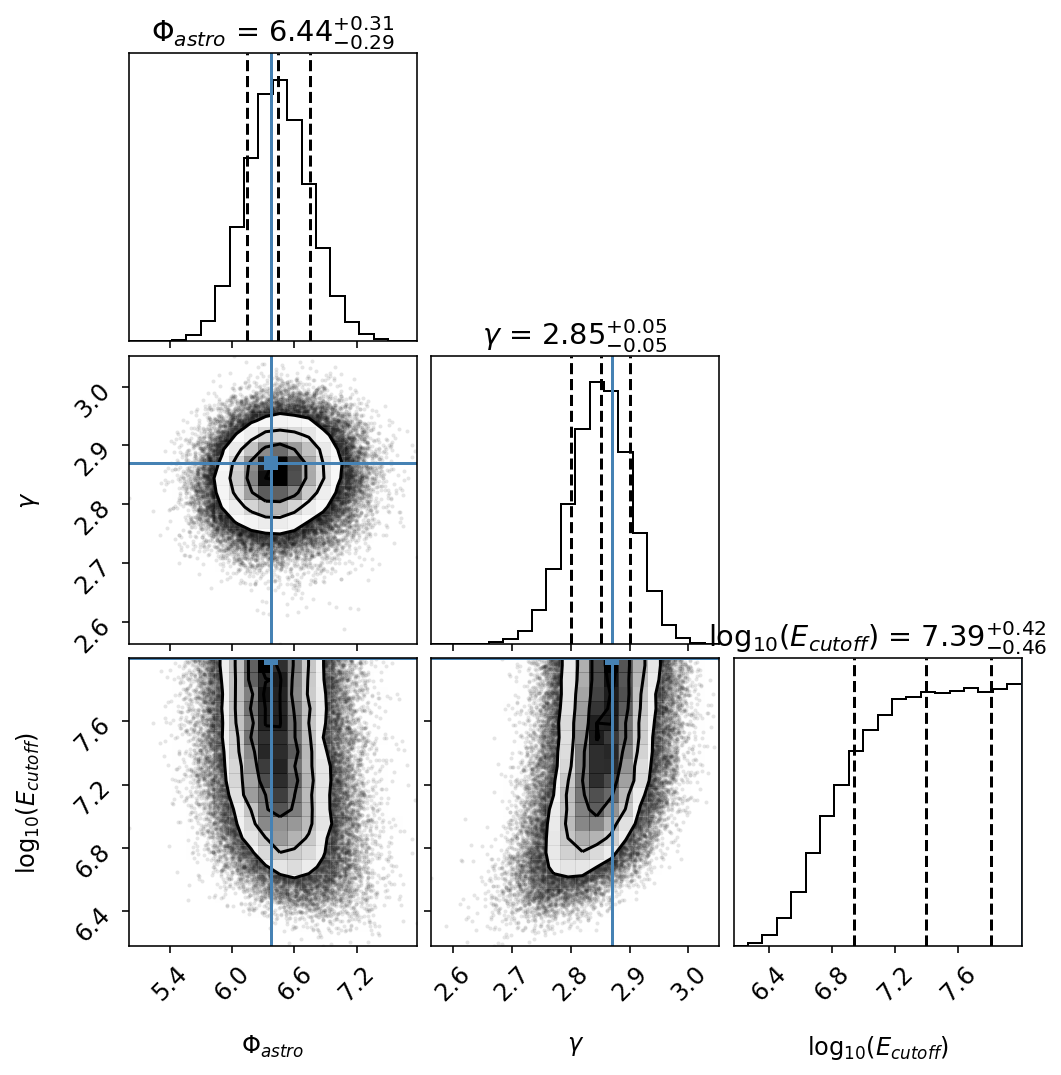

In [131]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[6.37, 2.87, 8],
    quantiles=[0.16,0.5,0.84], # param at 0.5 quantile represents 'best-fit', difference of param under 0.16 and 0.84 quantiles represents uncertainty. 
    show_titles=True,
)

## 3. HESE + myown; norm vs. gamma; data: no cutoff, model: no cutoff

In [104]:
def llh(norm, gamma, cutoff): # data: no cutoff
    astroFluxArrPredicted = astroFlux(norm,gamma,10**cutoff) # varying flux 
    
    dNPredNuMuHESE = dNobs(astroFluxArrPredicted, AeffNuMuHESE, Livetime)
    dNPredNuMuBarHESE = dNobs(astroFluxArrPredicted, AeffNuMuBarHESE, Livetime)
    dNPredNuEHESE = dNobs(astroFluxArrPredicted, AeffNuEHESE, Livetime)
    dNPredNuEBarHESE = dNobs(astroFluxArrPredicted, AeffNuEBarHESE, Livetime)
    dNPredNuTauHESE = dNobs(astroFluxArrPredicted, AeffNuTauHESE, Livetime)
    dNPredNuTauBarHESE = dNobs(astroFluxArrPredicted, AeffNuTauBarHESE, Livetime)
    
    dNPredTotHESE = dNPredNuMuHESE +\
                    dNPredNuMuBarHESE +\
                    dNPredNuEHESE +\
                    dNPredNuEBarHESE +\
                    dNPredNuTauHESE +\
                    dNPredNuTauBarHESE
    
    dNPredNuMuMy = dNobs(astroFluxArrPredicted, AeffNuMuMY, Livetime)/1e4
    
    dNPredTot = dNPredTotHESE + dNPredNuMuMy
#     print(dNPredTot,dNPredTotHESE,dNPredNuMuMy)
    # calculating log likelihood using Sterling approx
    
    llh = np.where(dNObsTot > 0, 
                   dNObsTot*np.log(dNPredTot)-dNPredTot-(dNObsTot*np.log(dNObsTot)-dNObsTot),
                   -dNPredTot)
    llh = np.sum(llh)
    return llh

def negllh(norm, gamma, cutoff):
    return -llh(norm, gamma, cutoff)

In [105]:
m = mi.Minuit(negllh,
              norm=6.,gamma=2.9,cutoff=np.inf,
              limit_norm=(0.01,10),limit_gamma=(1.5,3.5),limit_cutoff=None,
              fix_norm=False,fix_gamma=False,fix_cutoff=True,
              errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
             )

In [106]:
m.migrad()

------------------------------------------------------------------
| FCN = 22.69                   |      Ncalls=36 (36 total)      |
| EDM = 7e-08 (Goal: 0.0001)    |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | norm   |   6.38    |   0.30    |            |            |  0.01   |   10    |       |
| 1 | gamma  |   2.83    |   0.04    |            |            |   1.5   |   3.5   |       |
| 2 | cutoff |    inf    |    inf    |            |            |         |         |  yes  |
--------------------------------------------------------------------------------------------

In [107]:
llh_best = llh(m.values[0],m.values[1],m.values[2])

In [108]:
# 2d scan
norms = np.linspace(0.01,10,NBins) # norm
gammas = np.linspace(1.5,3.5,NBins) # gamma
ns = []
gs = []
ls = []
for i in range(0,len(norms)):
    for j in range(0,len(gammas)):
        ns.append(norms[i])
        gs.append(gammas[j])
        m_tmp = mi.Minuit(negllh,
                          norm=norms[i],gamma=gammas[j],cutoff=np.inf,
                          limit_norm=None,limit_gamma=None,limit_cutoff=None,
                          fix_norm=True,fix_gamma=True,fix_cutoff=True,
                          errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                         )
        m_tmp.migrad()
        ls.append(llh(norms[i],gammas[j],np.inf))
ls = np.array(ls)
t = -2 * (ls - llh_best) # -2 ln (L/L_best_estimate)

# 1d scan 
nns,nnprof,_ = m.mnprofile("norm",bound=(0.01,10),bins=NBins)
nnprof = -2 * (-nnprof - llh_best)

ggs,ggprof,_ = m.mnprofile("gamma",bound=(1.5,3.5),bins=NBins)
ggprof = -2 * (-ggprof - llh_best)

In [109]:
CL = [2.3, 6.0, 9.21] # chi2 distribution of 2 dof, Confidence Intervals

# path of best fits
best_norms = []
for i in range(0,len(gammas)):
    m_tmp = mi.Minuit(negllh,
                      norm=6,gamma=gammas[i],cutoff=np.inf,
                      limit_norm=(0.01,10),limit_gamma=(1.5,3.5),limit_cutoff=None,
                      fix_norm=False,fix_gamma=True,fix_cutoff=True,
                      errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                     )
    m_tmp.migrad()
    best_norms.append(m_tmp.values[0])

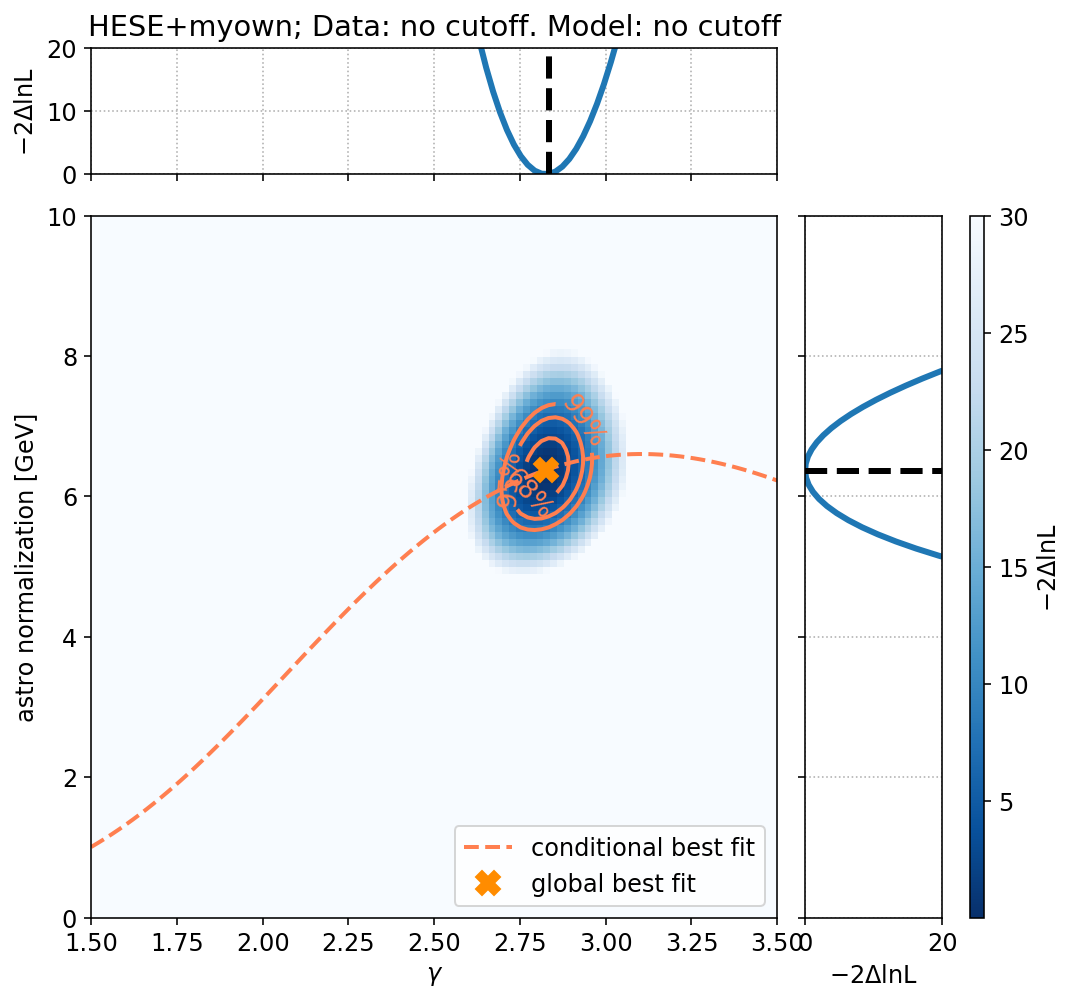

In [110]:
plt.figure(figsize=(8,8))

gspec = gridspec.GridSpec(2, 3,width_ratios=[5,1,0.1], height_ratios=[0.9,5], wspace=0.1, hspace=0.1)

ax1 = plt.subplot(gspec[0])

plt.plot(ggs,ggprof,lw=3)
plt.axvline(ggs[ggprof==np.min(ggprof)],ls='--',lw=3,color='black')
plt.xlim(1.5,3.5)
plt.ylim(0,20)
plt.ylabel(r'$-2\Delta$lnL')
plt.title('HESE+myown; Data: no cutoff. Model: no cutoff')
ax1.tick_params(labelbottom=False)    
plt.grid(True,which='both',zorder=0,linestyle=':')
axbar = plt.subplot(gspec[5])

ax2 = plt.subplot(gspec[3])

h,yy,xx,img=plt.hist2d(gs,ns,weights=t.clip(-np.inf,30),bins=[len(gammas),len(norms)],range=[[1.5,3.5],[0,10]],cmap='Blues_r')#,norm=LogNorm())
plt.plot(gammas,best_norms,'--',color='coral',lw=2,label='conditional best fit')
plt.plot(m.values[1],m.values[0],'X',color='darkorange',ms=12,label='global best fit')
cbar = plt.colorbar(cax=axbar)
cbar.set_label(r'$-2\Delta$lnL') 
CS=plt.contour(h.transpose(),extent=[np.min(gammas),np.max(gammas),np.min(norms),np.max(norms)],levels=CL,colors='coral',linewidths=2)
plt.clabel(CS,fmt={CL[0]:'68%',CL[1]:'95%',CL[2]:'99%'},fontsize=13)
plt.legend(loc='lower right',prop={'size': 12})
plt.xlim(1.5,3.5)
plt.ylim(0,10)
plt.xlabel(r'$\gamma$')
plt.ylabel('astro normalization [GeV]')

ax3 = plt.subplot(gspec[4])

plt.plot(nnprof,nns,lw=3)
plt.axhline(nns[nnprof==np.min(nnprof)],ls='--',lw=3,color='black')
ax3.tick_params(labelleft=False)
plt.xlim(0,20)
plt.ylim(0,10)
plt.xlabel(r'$-2\Delta$lnL')
plt.grid(True,which='both',zorder=0,linestyle=':')

plt.show()

## 4. HESE + myown; cutoff vs. gamma; data: no cutoff, model: cutoff

In [111]:
m = mi.Minuit(negllh,
              norm=6.4,gamma=2.5,cutoff=7,
              limit_norm=(0.01,10),limit_gamma=(1.5,3.5),limit_cutoff=(6,7.5),
              fix_norm=False,fix_gamma=False,fix_cutoff=False,
              error_norm=0.125,error_gamma=0.25,error_cutoff=0.1,
              errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
             )

In [112]:
m.migrad()

------------------------------------------------------------------
| FCN = 24.25                   |     Ncalls=108 (108 total)     |
| EDM = 1.53e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | norm   |   6.41    |   0.30    |            |            |  0.01   |   10    |       |
| 1 | gamma  |   2.81    |   0.04    |            |            |   1.5   |   3.5   |       |
| 2 | cutoff |   7.50    |   0.13    |            |            |    6    |   7.5   |       |
--------------------------------------------------------------------------------------------

In [113]:
llh_best = llh(m.values[0],m.values[1],m.values[2])

In [114]:
# 2d scan
gammas = np.linspace(1.5,3.5,NBins) # gamma
cutoffs = np.linspace(6,7.5,NBins) # cutoff
cs = []
gs = []
ls = []
for i in range(0,len(gammas)):
    for j in range(0,len(cutoffs)):
        gs.append(gammas[i])
        cs.append(cutoffs[j])
        m_tmp = mi.Minuit(negllh,
                          norm=6.,gamma=gammas[i],cutoff=cutoffs[j],
                          limit_norm=(0.01,10),limit_gamma=(1.5,3.5),limit_cutoff=(6,7.5),
                          fix_norm=False,fix_gamma=True,fix_cutoff=True,
                          error_norm=0.125,error_gamma=0.25,error_cutoff=0.1,
                          errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                         )
        m_tmp.migrad()
        ls.append(llh(m_tmp.values[0],gammas[i],cutoffs[j]))
ls = np.array(ls)
t = -2 * (ls - llh_best) # -2 ln (L/L_best_estimate)

In [115]:
# 1d scan 
ggs,ggprof,_ = m.mnprofile("gamma",bound=(1.5,3.5),bins=NBins)
ggprof = -2 * (-ggprof - llh_best)

ccs,ccprof,_ = m.mnprofile("cutoff",bound=(6,7.5),bins=NBins)
ccprof = -2 * (-ccprof - llh_best)

# path of best fits
best_cutoffs = []
gammas_dense = np.linspace(np.min(gammas),np.max(gammas),50)
for i in range(0,len(gammas_dense)):
    m_tmp = mi.Minuit(negllh,
                      norm=6,gamma=gammas_dense[i],cutoff=7,
                      limit_norm=(0.01,10),limit_gamma=(1.5,3.5),limit_cutoff=(6,7.5),
                      fix_norm=False,fix_gamma=True,fix_cutoff=False,
                      error_norm=0.125,error_gamma=0.25,error_cutoff=0.1,
                      errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                     )
    m_tmp.migrad()
    best_cutoffs.append(m_tmp.values[2])

CL = [2.3, 6.0, 9.21] # chi2 distribution of 2 dof, Confidence Intervals

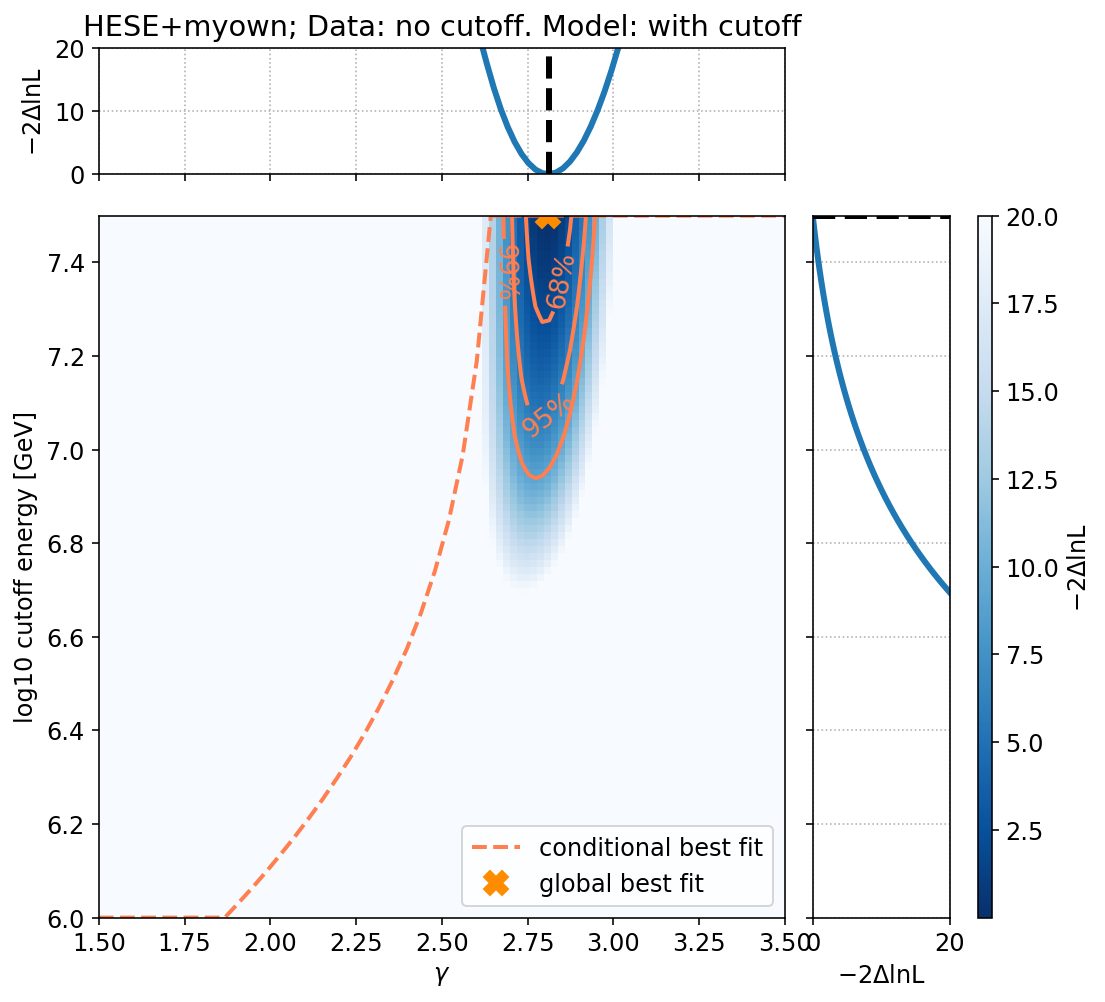

In [116]:
plt.figure(figsize=(8,8))

gspec = gridspec.GridSpec(2, 3,width_ratios=[5,1,0.1], height_ratios=[0.9,5], wspace=0.1, hspace=0.1)

ax1 = plt.subplot(gspec[0])

plt.plot(ggs,ggprof,lw=3)
plt.axvline(ggs[ggprof==np.min(ggprof)],ls='--',lw=3,color='black')
plt.xlim(1.5,3.5)
plt.ylim(0,20)
plt.ylabel(r'$-2\Delta$lnL')
plt.title('HESE+myown; Data: no cutoff. Model: with cutoff')
ax1.tick_params(labelbottom=False)    
plt.grid(True,which='both',zorder=0,linestyle=':')

axbar = plt.subplot(gspec[5])

ax2 = plt.subplot(gspec[3])

h,yy,xx,img=plt.hist2d(gs,cs,weights=t.clip(-np.inf,20),bins=[len(gammas),len(cutoffs)],range=[[1.5,3.5],[6,7.5]],cmap='Blues_r')#,norm=LogNorm())
plt.plot(gammas_dense,best_cutoffs,'--',color='coral',lw=2,label='conditional best fit')
plt.plot(m.values[1],m.values[2],'X',color='darkorange',ms=12,label='global best fit')
cbar = plt.colorbar(cax=axbar)
cbar.set_label(r'$-2\Delta$lnL') 
CS=plt.contour(h.transpose(),extent=[np.min(gammas),np.max(gammas),np.min(cutoffs),np.max(cutoffs)],levels=CL,colors='coral',linewidths=2)
plt.clabel(CS,fmt={CL[0]:'68%',CL[1]:'95%',CL[2]:'99%'},fontsize=13)
plt.legend(loc='lower right',prop={'size': 12})
plt.xlim(1.5,3.5)
plt.ylim(6,7.5)
plt.xlabel(r'$\gamma$')
plt.ylabel('log10 cutoff energy [GeV]')

ax3 = plt.subplot(gspec[4])

plt.plot(ccprof,ccs,lw=3)
plt.axhline(ccs[ccprof==np.min(ccprof)],ls='--',lw=3,color='black')
ax3.tick_params(labelleft=False)
plt.xlim(0,20)
plt.ylim(6,7.5)
plt.xlabel(r'$-2\Delta$lnL')
plt.grid(True,which='both',zorder=0,linestyle=':')

plt.show()

In [117]:
gamma_68,cutoff_68 = CS.allsegs[0][0][:,0],CS.allsegs[0][0][:,1]
gamma_95,cutoff_95 = CS.allsegs[1][0][:,0],CS.allsegs[1][0][:,1]

### 4.5 MCMC

In [135]:
def llh_mcmc(x): # data: no cutoff
    norm, gamma, log_cutoff = x
    if norm<0:
        return -np.inf
    if log_cutoff > 8 or log_cutoff < 6:
        return -np.inf
    
    astroFluxArrPredicted = astroFlux(norm,gamma,10**log_cutoff) # varying flux 
    
    dNPredNuMuHESE = dNobs(astroFluxArrPredicted, AeffNuMuHESE, Livetime)
    dNPredNuMuBarHESE = dNobs(astroFluxArrPredicted, AeffNuMuBarHESE, Livetime)
    dNPredNuEHESE = dNobs(astroFluxArrPredicted, AeffNuEHESE, Livetime)
    dNPredNuEBarHESE = dNobs(astroFluxArrPredicted, AeffNuEBarHESE, Livetime)
    dNPredNuTauHESE = dNobs(astroFluxArrPredicted, AeffNuTauHESE, Livetime)
    dNPredNuTauBarHESE = dNobs(astroFluxArrPredicted, AeffNuTauBarHESE, Livetime)
    
    dNPredTotHESE = dNPredNuMuHESE +\
                    dNPredNuMuBarHESE +\
                    dNPredNuEHESE +\
                    dNPredNuEBarHESE +\
                    dNPredNuTauHESE +\
                    dNPredNuTauBarHESE
    
    dNPredNuMuMy = dNobs(astroFluxArrPredicted, AeffNuMuMY, Livetime)/1e4
    
    dNPredTot = dNPredTotHESE + dNPredNuMuMy
#     print(dNPredTot,dNPredTotHESE,dNPredNuMuMy)
    # calculating log likelihood using Sterling approx
    
    llh = np.where(dNObsTot > 0, 
                   dNObsTot*np.log(dNPredTot)-dNPredTot-(dNObsTot*np.log(dNObsTot)-dNObsTot),
                   -dNPredTot)
    llh = np.sum(llh)
    return llh

In [136]:
pos = [6.37,2.87,7.5] + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

In [142]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, llh_mcmc)
sampler.run_mcmc(pos, 50000, progress=True);

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply
100%|██████████| 50000/50000 [31:06<00:00, 26.79it/s]


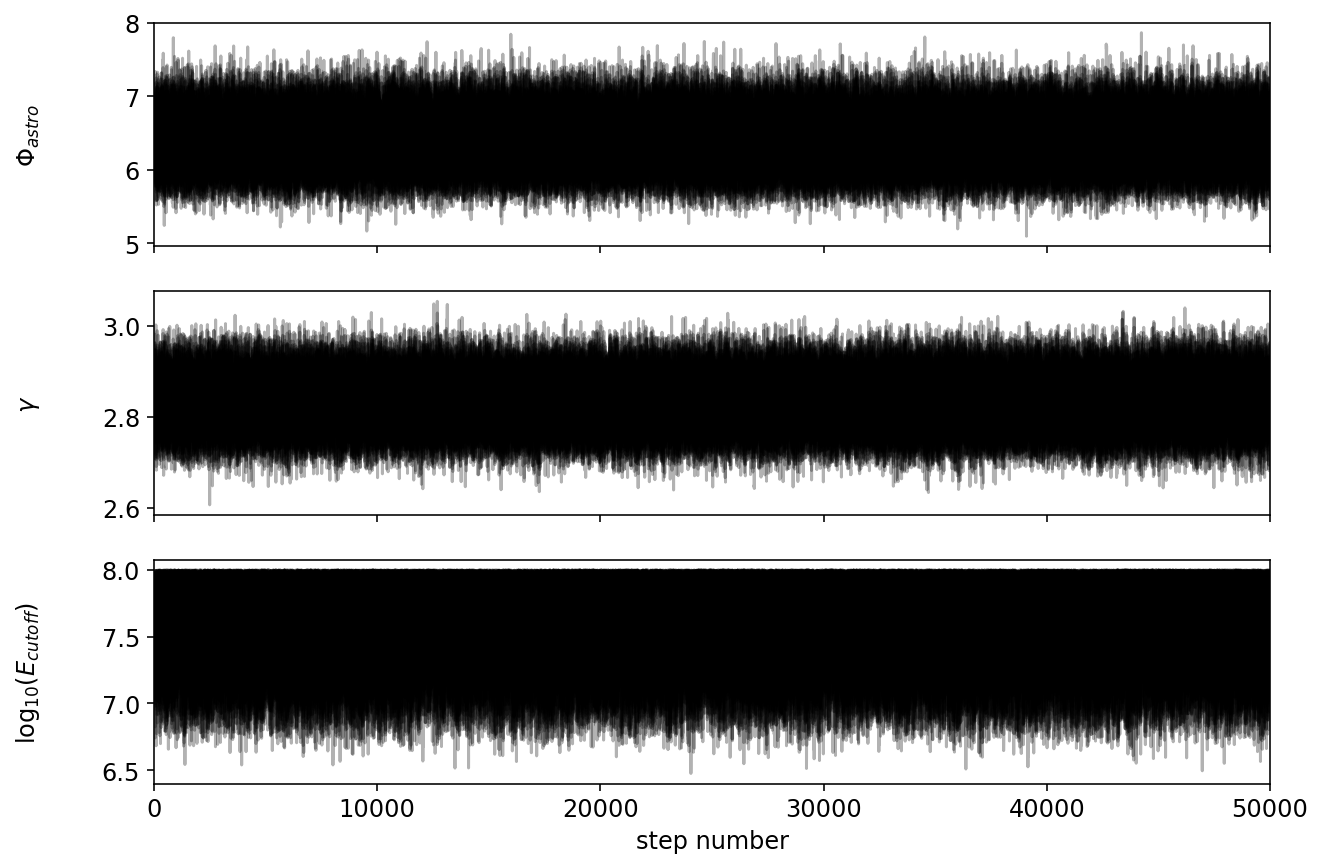

In [143]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Phi_{astro}$", r"$\gamma$", r"$\log_{10}(E_{cutoff})$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [144]:
tau = sampler.get_autocorr_time()
print(tau)

[44.08567914 42.72486714 48.02566734]


In [145]:
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)

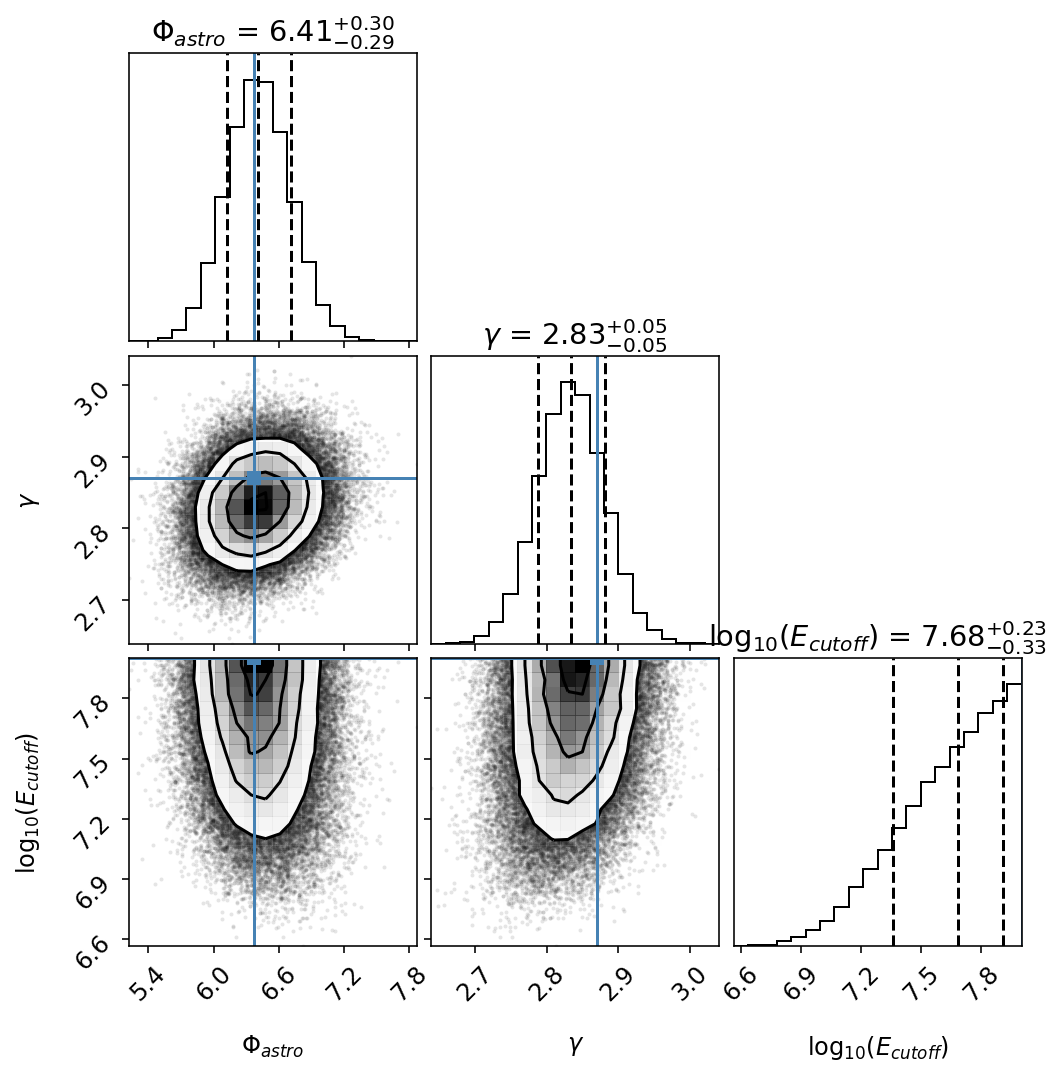

In [146]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[6.37, 2.87, 8],
    quantiles=[0.16,0.5,0.84], # param at 0.5 quantile represents 'best-fit', difference of param under 0.16 and 0.84 quantiles represents uncertainty. 
    show_titles=True,
)

# 5. comparison 2 contours

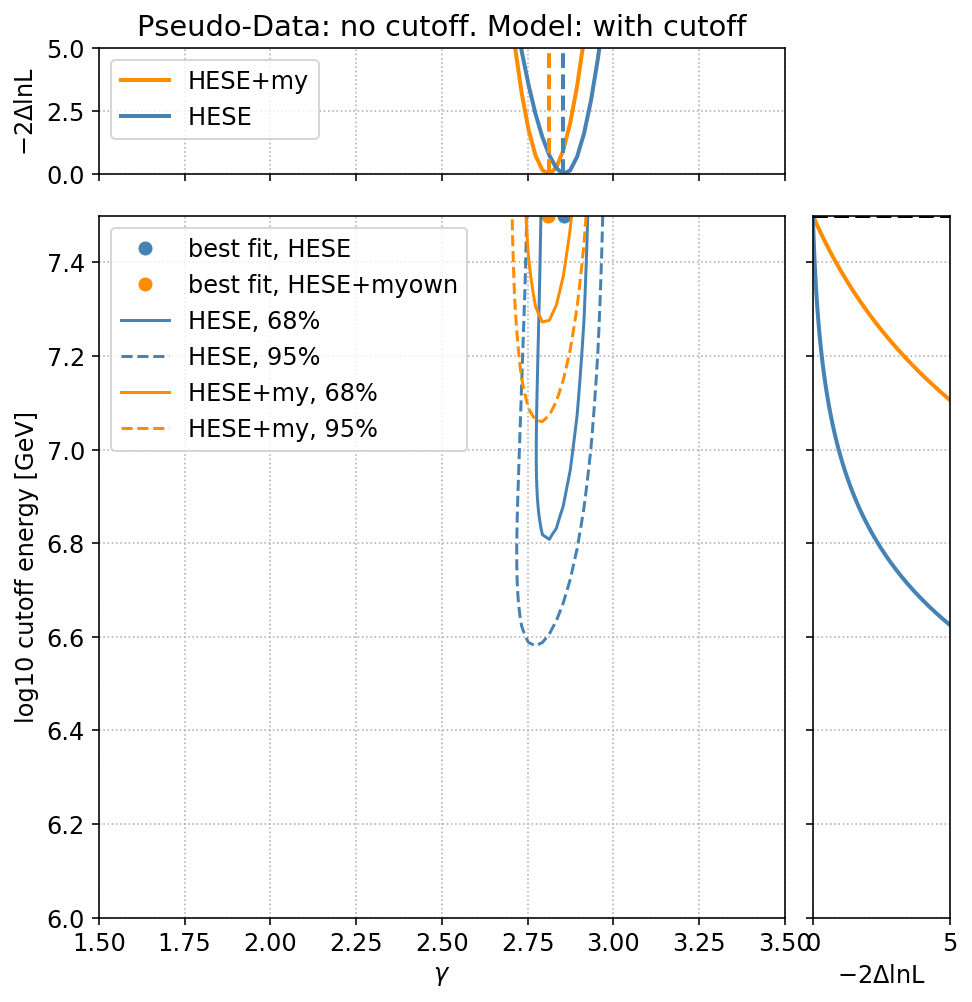

In [118]:
# Comparison 
plt.figure(figsize=(8,8))

gspec = gridspec.GridSpec(2, 3,width_ratios=[5,1,0.1], height_ratios=[0.9,5], wspace=0.1, hspace=0.1)

ax1 = plt.subplot(gspec[0])

plt.plot(ggs,ggprof,lw=2,color='darkorange',label='HESE+my')
plt.plot(ggs_before,ggprof_before,lw=2,color='steelblue',label='HESE ') # HESE 
plt.axvline(ggs[ggprof==np.min(ggprof)],ls='--',lw=2,color='darkorange')
plt.axvline(ggs[ggprof_before==np.min(ggprof_before)],ls='--',lw=2,color='steelblue')

# c = np.abs(ggprof-1)
# c.sort()
# left_, right_ = ggs[np.abs(ggprof-1)==c[0]], ggs[np.abs(ggprof-1)==c[1]]
# plt.axvline(left_,ls='--',lw=1,color='darkorange',label='left')
# plt.axvline(right_,ls='--',lw=1,color='darkorange',label='left')

# c = np.abs(ggprof_before-1)
# c.sort()
# left_, right_ = ggs[np.abs(ggprof_before-1)==c[0]], ggs[np.abs(ggprof_before-1)==c[1]]
# plt.axvline(left_,ls='--',lw=1,color='darkorange',label='left')
# plt.axvline(right_,ls='--',lw=1,color='darkorange',label='left')

# plt.axvline(ggs[ggprof>0.95],ls='--',lw=1,color='black')

plt.xlim(1.5,3.5)
plt.ylim(0,5)
plt.legend()
plt.ylabel(r'$-2\Delta$lnL')
plt.title('Pseudo-Data: no cutoff. Model: with cutoff')
ax1.tick_params(labelbottom=False)    
plt.grid(True,which='both',zorder=0,linestyle=':')

ax2 = plt.subplot(gspec[3])
plt.plot(m_before.values[1],m_before.values[2],'o',color='steelblue',ms=6,label='best fit, HESE ')
plt.plot(m.values[1],m.values[2],'o',color='darkorange',ms=6,label='best fit, HESE+myown')
cbar.set_label(r'$-2\Delta$lnL') 
# CS=plt.contour(h.transpose(),extent=[np.min(gammas),np.max(gammas),np.min(cutoffs)),np.max(cutoffs))],levels=CL,colors='coral',linewidths=2)
plt.plot(gamma_68_before,cutoff_68_before,color='steelblue',label='HESE, 68%') # HESE 
plt.plot(gamma_95_before,cutoff_95_before,'--',color='steelblue',label='HESE, 95%') # HESE 

plt.plot(gamma_68,cutoff_68,color='darkorange',label='HESE+my, 68%') # HESE + myown
plt.plot(gamma_95,cutoff_95,'--',color='darkorange',label='HESE+my, 95%') # HESE + myown

# plt.clabel(CS,fmt={CL[0]:'68%',CL[1]:'95%',CL[2]:'99%'},fontsize=13)
plt.legend(loc='upper left',prop={'size': 12})
plt.xlim(1.5,3.5)
plt.ylim(6,7.5)
plt.xlabel(r'$\gamma$')
plt.ylabel('log10 cutoff energy [GeV]')
plt.grid(True,which='both',zorder=0,linestyle=':')

ax3 = plt.subplot(gspec[4])

plt.plot(ccprof,ccs,lw=2,color='darkorange',label='HESE+my')
plt.plot(ccprof_before,ccs_before,lw=2,color='steelblue',label='HESE ') # HESE
plt.axhline(ccs[ccprof==np.min(ccprof)],ls='--',lw=2,color='black')
ax3.tick_params(labelleft=False)
plt.xlim(0,5)
plt.ylim(6,7.5)
# plt.legend()
plt.xlabel(r'$-2\Delta$lnL')
plt.grid(True,which='both',zorder=0,linestyle=':')

plt.show()